# **Spatio-temporal clustering for syndromic surveillance**

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb

In [55]:
# import cleaned and prepared data of consultations in RW
rw_data = pd.read_pickle("data/rw-cleaned-prepared-dynamic-data-phase1.pickle")

In [56]:
for c in rw_data.columns:
    print(c)

medical_case_id
medical_case_local_id
medical_case_consent
medical_case_isEligible
medical_case_redcap
medical_case_consultation_date
medical_case_closed_at
medical_case_force_close
medical_case_redcap_flag
medical_case_duplicate
medical_case_is_drop
medical_case_app_version
patient_id
patient_birthdate
patient_gender
patient_local_patient_id
patient_consent
patient_redcap
patient_duplicate
patient_other_uid
patient_other_study_id
patient_other_group_id
patient_merged_with
patient_is_drop
patient_merged
patient_status
patient_related_ids
patient_other_id
health_facility_id
health_facility_group_id
health_facility_longitude
health_facility_latitude
health_facility_hf_mode
health_facility_name
health_facility_country
health_facility_area
health_facility_is_drop
health_facility_council
device_id
device_name
device_health_facility_id
device_health_worker
device_mac_address
device_last_seen
version_id
version_medal_c_id
version_name
version_consent_management
version_study
version_is_arm_co

# Data selection
Only pick columns relevant for the spatio-temporal clustering of symptoms. Relevant columns are:
1. time = "medical_case_consultation_date"
2. space
    - hf location = "health_facility_longitude" & "health_facility_latitude"
    - location of patient's home: "BD9 - Village (Umudugudu) - 8062" (cleaned in columns: ....)
3. demographic: 
    - age = "patient_birthdate"
    - sex = "patient_gender"
    - columns with BD in the beginning
    - columns with BM in the beginning
    - diagnosis (= potential labels for clusters) = columns with DF (, CH, A) in the beginning
4. symptoms = columns with CC, PE and (S, OS, A) in the beginning

Note:
- columns: District_Name, Sector_Name, Cell_Name, Village_Name contain the original village values extracted from the BD9...village.. column
- columns: best_match_village, best_match_cell, best_match_sector, best_match_district contain the best matching villages from the master lists
- columns: District, Sector, Cell, Village contain either the orignal village (if the village was correctly inputted in cdss) or the best matching village from the master list

In [57]:
columns_to_keep = [
    "medical_case_id",
    "medical_case_consultation_date_day",
    "patient_id",
    "patient_birthdate",
    "patient_gender",
    "health_facility_id",
    "health_facility_group_id",
    "health_facility_longitude",
    "health_facility_latitude",
    "health_facility_name",
]

demographic_columns = [
    #"patient_id",
    "patient_age",
    "patient_gender"
]

spatio_temporal_columns = [
    "medical_case_consultation_date_day", # time
    "health_facility_name", "health_facility_longitude", "health_facility_latitude",  #spatial variant 1 = hf location
    "District", "Sector", "Cell", "Village", "longitude_village", "latitude_village" #spatial variant 2 = patient's origin
]

## Symptoms of interest
The following symptoms are used by clinicians to find diagnoses potentially missed by the CDSS. They will be used for clustering which inter alias aims to do same. 
- PE212...Respiratory.rate..breaths.min....8469
- S39...Cough...7817
- PE18...Chest.indrawing...7811
- S180...How.is.the.infant.feeding.currently....7516
- S46...Convulsions.in.present.illness...8355
- BC - Axillary temperature - 7823 categorical
- PE125...Observation.of.movement...8388
- S96...Unable.to.drink.or.breastfeed...7871
- S157...Vomiting.everything...8026
- OS9...Unconscious.or.Lethargic..Unusually.sleepy....7378
- PE63 - Stiff neck - 8391
- PE19...Stridor.in.calm.child...7812
- S42 - Duration of fever (days) - 7819 categorical
- S124 - Significant weight loss – 7539
- S118 - Significant hemoptysis (>1 episode) - 7941
- S176 - Cough duration (days) - 7731 categorical
- E46 - Recent close contact with somebody with TB – 7820
- DF130 - fever without source: presumed bacterial infection – 30851 
- DF129 - fever without source: presumed viral illness - 30853 
- PE220 - Identifiable source of fever? – 8399
- A51 - Malaria rapid diagnostic test - 7838 categorical
- A50 - Microscopy for malarial parasites - 7837 categorical 
- A55 - Urinary dipstick – 7648
- PE134 - Measles rash and associated signs – 8386
- PE109 - Scarlet fever rash - 8344
- PE106 - Non specific viral rash – 7930
- PE218 - Unexplained bleeding – 8107
- S153 - Diarrhea (stools are looser or more watery than normal) – 7649
- S98 - Number of loose or liquid stools over the past 24 hours - 7882 categorical
- S149 - Yellow appearing skin or eyes (jaundice) – 7630
- PE191 - Jaundice – 8036
- S74 - Abnormal vaginal discharge – 8377
- S81 - Urethral discharge – 7810
- S79 - Genital lesion – 7867
- BC7 - Weight for age (z-score) - 8434 categorical
- BC95 - Weight for height - 7451 categorical
- BC - MUAC in cm - 7833 categorical

The clinicians also use all columns containing the following symptom within "-":
- fever without source: presumed bacterial infection (e. g. "DF130 - fever without source: presumed bacterial infection – 30851")
- fever without source: presumed viral illness (e. g. "DF129 - fever without source: presumed viral illness - 30853")
- suspicion of tuberculosis

In [58]:
symptoms_of_interest = ["PE212 - Respiratory rate (breaths/min) - 8469",
    "S39 - Cough - 7817", 
    "PE18 - Chest indrawing - 7811",
    "S180 - How is the infant feeding currently? - 7516",
    "S46 - Convulsions in present illness - 8355",
    "BC - Axillary temperature - 7823 categorical",
    "PE125 - Observation of movement - 8388",
    "S96 - Unable to drink or breastfeed - 7871",
    "S157 - Vomiting everything - 8026",
    "OS9 - Unconscious or Lethargic (Unusually sleepy) - 7378",
    "PE63 - Stiff neck - 8391",
    "PE19 - Stridor in calm child - 7812",
    "S42 - Duration of fever (days) - 7819 categorical",
    "S124 - Significant weight loss - 7539",
    "S118 - Significant hemoptysis (>1 episode) - 7941",
    "S176 - Cough duration (days) - 7731 categorical",
    "E46 - Recent close contact with somebody with TB - 7820",
    "PE220 - Identifiable source of fever? - 8399",
    "A55 - Urinary dipstick - 7648",
    "PE134 - Measles rash and associated signs - 8386",
    "PE109 - Scarlet fever rash - 8344",
    "PE106 - Non specific viral rash - 7930",
    "PE218 - Unexplained bleeding - 8107",
    "S153 - Diarrhea (stools are looser or more watery than normal) - 7649",
    "S98 - Number of loose or liquid stools over the past 24 hours - 7882 categorical",
    "S149 - Yellow appearing skin or eyes (jaundice) - 7630",
    "PE191 - Jaundice - 8036",
    "S74 - Abnormal vaginal discharge - 8377",
    "S81 - Urethral discharge - 7810",
    "S79 - Genital lesion - 7867",
    "BC7 - Weight for age (z-score) - 8434 categorical",
    "BC95 - Weight for height - 7451 categorical",
    "BC - MUAC in cm - 7833 categorical"
]

# add symptoms which appear in several columns because they are actually diagnoses
symptoms_to_find = ["fever without source: presumed bacterial infection", "fever without source: presumed viral illness", "suspicion of tuberculosis"]
symptoms_to_add = [s for symp in symptoms_to_find for s in rw_data.columns if symp in s]
print("Adding the following", len(symptoms_to_add), "symptoms to symptoms_of_interest:\n", symptoms_to_add)
symptoms_of_interest = symptoms_of_interest + symptoms_to_add

Adding the following 12 symptoms to symptoms_of_interest:
 ['DF130 - fever without source: presumed bacterial infection - 30851', 'DF - fever without source: presumed bacterial infection - 26194', 'DF130 - fever without source: presumed bacterial infection - 8480', 'DF130 - fever without source: presumed bacterial infection - 30602', 'DF129 - fever without source: presumed viral illness - 30853', 'DF - fever without source: presumed viral illness - 26192', 'DF129 - fever without source: presumed viral illness - 8481', 'DF129 - fever without source: presumed viral illness - 30604', 'DF9 - suspicion of tuberculosis - 30886', 'DF - suspicion of tuberculosis - 26232', 'DF9 - suspicion of tuberculosis - 8539', 'DF9 - suspicion of tuberculosis - 30643']


## Diagnoses of interest
List of diagnoses which is used to check if clustering goes beyond clustering just these diagnoses.

In [59]:
diagnoses_of_interest = [col for col in rw_data.columns if ((col[0:2] == "DF") & (~(col in symptoms_of_interest)))] # dont include diagnoses which are used as symptoms and thus features for clustering
print("number of diagnoses of interest:", len(diagnoses_of_interest))

# TODO merge diagnoses with same name together NOTE this is been taken care of later?
# # add symptoms which appear in several columns
    #symptoms_to_find = ["fever without source: presumed bacterial infection", "fever without source: presumed viral illness"]
    #symptoms_to_add = [s for symp in symptoms_to_find for s in rw_data.columns if symp in s]
    #print("Adding the following", len(symptoms_to_add), "symptoms to symptoms_of_interest:\n", symptoms_to_add)
    #symptoms_of_interest = symptoms_of_interest + symptoms_to_add

number of diagnoses of interest: 1042


In [60]:
# select data for clustering
data = rw_data[np.concatenate((demographic_columns, symptoms_of_interest))]

# print list of columns used as features for clustering
for col in data.columns:
    print(col)

patient_age
patient_gender
PE212 - Respiratory rate (breaths/min) - 8469
S39 - Cough - 7817
PE18 - Chest indrawing - 7811
S180 - How is the infant feeding currently? - 7516
S46 - Convulsions in present illness - 8355
BC - Axillary temperature - 7823 categorical
PE125 - Observation of movement - 8388
S96 - Unable to drink or breastfeed - 7871
S157 - Vomiting everything - 8026
OS9 - Unconscious or Lethargic (Unusually sleepy) - 7378
PE63 - Stiff neck - 8391
PE19 - Stridor in calm child - 7812
S42 - Duration of fever (days) - 7819 categorical
S124 - Significant weight loss - 7539
S118 - Significant hemoptysis (>1 episode) - 7941
S176 - Cough duration (days) - 7731 categorical
E46 - Recent close contact with somebody with TB - 7820
PE220 - Identifiable source of fever? - 8399
A55 - Urinary dipstick - 7648
PE134 - Measles rash and associated signs - 8386
PE109 - Scarlet fever rash - 8344
PE106 - Non specific viral rash - 7930
PE218 - Unexplained bleeding - 8107
S153 - Diarrhea (stools are l

# Data preparation

The clinicians also use these columns which we gonna merge into one feature with "microscopy" as the decisive column, i. e. if both columns are not NAN for a consultation then the value in the "microscopy" column is copied for the final merged feature. 
- "A51 - Malaria rapid diagnostic test - 7838 categorical",
- "A50 - Microscopy for malarial parasites - 7837 categorical"

Note instruction by domain experts:

"first replace all ``Test not available`` with blank in both [malaria] variables. Then create one variable by taking the value of microscopy if it's present and otherwise, taking the value of mRDT. Then if the result is positive it can be 1 and if negative 0."

In [61]:
# engineer malaria feature based on instructions of domain experts
data["malaria"] = rw_data["A50 - Microscopy for malarial parasites - 7837 categorical"]#[e if e == np.nan else rw_data["A51 - Malaria rapid diagnostic test - 7838 categorical"][i] for i, e in enumerate(rw_data["A50 - Microscopy for malarial parasites - 7837 categorical"])]
data.loc[data["malaria"].isna(), "malaria"] == rw_data.loc[data["malaria"].isna(), "A51 - Malaria rapid diagnostic test - 7838 categorical"]

# number of consultation which have no value in "A50 - Microscopy for malarial parasites - 7837 categorical" but a value in "A50 - Microscopy for malarial parasites - 7837 categorical"
sum(rw_data["A50 - Microscopy for malarial parasites - 7837 categorical"].isna() & ~rw_data["A50 - Microscopy for malarial parasites - 7837 categorical"].isna())

C:\Users\sidla\AppData\Local\Temp\ipykernel_7492\3784921035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["malaria"] = rw_data["A50 - Microscopy for malarial parasites - 7837 categorical"]#[e if e == np.nan else rw_data["A51 - Malaria rapid diagnostic test - 7838 categorical"][i] for i, e in enumerate(rw_data["A50 - Microscopy for malarial parasites - 7837 categorical"])]


0

# Data normalization
Convert binary string features to numerical binary features as well as categorical features.

In [62]:
# convert "patient_gender" column into numeric binary column
data["patient_gender"] = [1 if gender == "female" else 0 for gender in data["patient_gender"]]

# convert "yes"/"no" columns and "Absent"/"Present" columns to binary columns and 'not_available' values to np.nan
data = data.apply(lambda x : x.replace({
    "Yes": 1, "No": 0, 
    "Absent": 0, "Present": 1, 
    "not_available": np.nan, 
    # special categorical symptoms need to be manually normalized
    "< 38 °C": 0, ">= 38°C": 1, # for BC - Axillary temperature - 7823
    "< 2 weeks": 0,  ">= 2 weeks": 1, # for S176 - Cough duration (days) - 7731 categorical
    "more than -2 z-score": 0, "-2 z-score": 1, "less than -2 z-score": 2, # for BC7 - Weight for age (z-score) - 8434 categorical and BC95 - Weight for height - 7451 categorical  
    '>= 12.5 cm': 0, '>= 11.5 < 12.5 cm': 1, '< 11.5 cm' : 2, # for BC - MUAC in cm - 7833 categorical
    'Accepted': 1, 'Manually added': 1, 'Rejected': 0, # for DF130 - fever without source: presumed bacterial infection - 30602 and DF129 - fever without source: presumed viral illness
    'Negative': 0, 'Test/Assessment is unavailable': np.nan, 'Positive': 1, # for malaria feature
    }), 
    axis=1
  )

# special categorical symptoms need to be manually normalized
# S180 - How is the infant feeding currently? - 7516: 'Feeding well' --> 0, 'Not feeding well' --> 1, 'Not feeding at all'--> 2
data["S180 - How is the infant feeding currently? - 7516"] = [0 if fed == "Feeding well" else 1 if fed == "Not feeding well" else 2 if fed == "Not feeding at all" else np.nan for fed in data["S180 - How is the infant feeding currently? - 7516"]]

# PE125 - Observation of movement - 8388: 'Movement without stimulation' --> 0, 'Movement only when stimulated' --> 1 'No movement even when stimulated' --> 2
data["PE125 - Observation of movement - 8388"] = [0 if moved == "Movement without stimulation" else 1 if moved == "Movement only when stimulated" else 2 if moved == "No movement even when stimulated" else np.nan for moved in data["PE125 - Observation of movement - 8388"]]

# S42 - Duration of fever (days) - 7819 categorical: '< 4 days' --> 0, '>= 4 days < 7 days' --> 1, '>= 7 days < 14 days' --> 2, '>= 14 days' --> 3
data["S42 - Duration of fever (days) - 7819 categorical"] = [0 if fever_duration == "< 4 days" else 1 if fever_duration == ">= 4 days < 7 days" else 2 if fever_duration == ">= 7 days < 14 days" else 3 if fever_duration == "> 14 days" else np.nan for fever_duration in data["S42 - Duration of fever (days) - 7819 categorical"]]

# A55 - Urinary dipstick - 7648: 'Normal' --> 0, 'Unavailable', np.nan, 'Pathologic' --> 1
data["A55 - Urinary dipstick - 7648"] = [0 if urin == "Normal" else 1 if urin == "Pathologic" else np.nan for urin in data["A55 - Urinary dipstick - 7648"]]

# S98 - Number of loose or liquid stools over the past 24 hours - 7882 categorical:  '<3' --> 0, '>=3' --> 1, '>=4' --> 2, '>=5' --> 3, '>=6' --> 4
data["S98 - Number of loose or liquid stools over the past 24 hours - 7882 categorical"] = [0 if nr_loose == "<3" else 1 if nr_loose == ">=3" else 2 if nr_loose == ">=4" else 3 if nr_loose == ">=5"  else 4 if nr_loose == ">=6" else np.nan for nr_loose in data["S98 - Number of loose or liquid stools over the past 24 hours - 7882 categorical"]]

# convert all features to numbers
data = data.astype(float)

# store names of categorical features
categorical_features = ["BC7 - Weight for age (z-score) - 8434 categorical",
  "BC95 - Weight for height - 7451 categorical",
  "BC - MUAC in cm - 7833 categorical",
  "S180 - How is the infant feeding currently? - 7516",
  "PE125 - Observation of movement - 8388",
  "S42 - Duration of fever (days) - 7819 categorical",
  "S98 - Number of loose or liquid stools over the past 24 hours - 7882 categorical",
]

C:\Users\sidla\AppData\Local\Temp\ipykernel_7492\3198383133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["patient_gender"] = [1 if gender == "female" else 0 for gender in data["patient_gender"]]


NOTE: for limitation: convrtng orgnal faturs to numrc ons leads to bas as not always the normal state s gven the value 0 e.g.  "< 38 °C": 0, ">= 38°C": 1, # for BC - Axillary temperature - 7823 --> a tmperature below thrty eght °C s not normal

Diagnoses which are used as symptoms, appear often in several columns, e.g.:The clinicians also use these columns which we gonna merge into one feature:
- DF9 - suspicion of tuberculosis – 30886
- DF - suspicion of tuberculosis – 26232
- DF9 - suspicion of tuberculosis – 8539
- DF9 - suspicion of tuberculosis - 30643 

or:
- DF129 - fever without source: presumed viral illness - 30853
- DF - fever without source: presumed viral illness - 26192
- DF129 - fever without source: presumed viral illness - 8481
- DF129 - fever without source: presumed viral illness - 30604

The next step is merging them into one.

In [63]:
# get features which are diagnosis, merge them and add replace them with merged and final feature
list_diagnoses_as_features = [col for col in data.columns if col[0:2] == "DF"]
diagnoses_data_as_features = data[list_diagnoses_as_features]
diagnoses_data_as_features.columns = [col.split(" - ")[1] for col in diagnoses_data_as_features.columns]
diagnoses_data_as_features = diagnoses_data_as_features.groupby(diagnoses_data_as_features.columns, axis=1, dropna=False).sum(min_count=1)

data = data[[col for col in data.columns if not (col in list_diagnoses_as_features)]] # remove old diagnoses features

# add final and merged diagnoses features
for col in diagnoses_data_as_features.columns:
    data[col] = diagnoses_data_as_features[col]
data

,patient_age,patient_gender,PE212 - Respiratory rate (breaths/min) - 8469,S39 - Cough - 7817,PE18 - Chest indrawing - 7811,S180 - How is the infant feeding currently? - 7516,S46 - Convulsions in present illness - 8355,BC - Axillary temperature - 7823 categorical,PE125 - Observation of movement - 8388,S96 - Unable to drink or breastfeed - 7871,...,S74 - Abnormal vaginal discharge - 8377,S81 - Urethral discharge - 7810,S79 - Genital lesion - 7867,BC7 - Weight for age (z-score) - 8434 categorical,BC95 - Weight for height - 7451 categorical,BC - MUAC in cm - 7833 categorical,malaria,fever without source: presumed bacterial infection,fever without source: presumed viral illness,suspicion of tuberculosis
0,0.0,0.0,36.0,1.0,0.0,NaN,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2.0,1.0,34.0,1.0,0.0,NaN,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2.0,1.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,0.0,1.0,NaN,1.0,0.0,NaN,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,0.0,1.0,0.0,NaN,NaN,NaN,0.0
4,1.0,0.0,38.0,1.0,0.0,NaN,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,10.0,0.0,36.0,1.0,0.0,NaN,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1507,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1508,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1509,3.0,0.0,24.0,1.0,0.0,NaN,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN


# Quality control of selected data for clustering

## Low variance

In [64]:
description_data = data.describe() # note: per default NaN values excluded
description_data 

,patient_age,patient_gender,PE212 - Respiratory rate (breaths/min) - 8469,S39 - Cough - 7817,PE18 - Chest indrawing - 7811,S180 - How is the infant feeding currently? - 7516,S46 - Convulsions in present illness - 8355,BC - Axillary temperature - 7823 categorical,PE125 - Observation of movement - 8388,S96 - Unable to drink or breastfeed - 7871,...,S74 - Abnormal vaginal discharge - 8377,S81 - Urethral discharge - 7810,S79 - Genital lesion - 7867,BC7 - Weight for age (z-score) - 8434 categorical,BC95 - Weight for height - 7451 categorical,BC - MUAC in cm - 7833 categorical,malaria,fever without source: presumed bacterial infection,fever without source: presumed viral illness,suspicion of tuberculosis
count,47886.000000,47886.000000,16905.000000,32055.000000,17461.000000,1402.000000,32943.000000,35088.000000,1397.000000,31561.000000,...,240.000000,8.0,29.000000,33010.000000,31614.000000,31419.000000,12244.000000,589.000000,783.000000,4288.000000
mean,3.268868,0.527628,34.776806,0.551053,0.016666,0.087019,0.001214,0.179264,0.022906,0.002725,...,0.441667,0.0,0.172414,0.124902,0.135035,0.008084,0.025155,0.896435,0.864623,0.097715
std,3.549796,0.499241,10.859431,0.497395,0.128019,0.313147,0.034825,0.383578,0.184008,0.052130,...,0.497623,0.0,0.384426,0.409157,0.445581,0.101228,0.156603,0.304955,0.342344,0.296963
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,35.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,5.000000,1.000000,40.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,15.000000,1.000000,144.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,...,1.000000,0.0,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
# check for low variance columns
low_var_threshold = 10 # NOTE does not make sense for binary features which make up the majority in this dataset
var_rw_data = description_data.loc[["std"]].transpose().dropna().sort_values(by=["std"])
var_rw_data

,std
S81 - Urethral discharge - 7810,0.000000
OS9 - Unconscious or Lethargic (Unusually sleepy) - 7378,0.019495
S46 - Convulsions in present illness - 8355,0.034825
E46 - Recent close contact with somebody with TB - 7820,0.038630
PE63 - Stiff neck - 8391,0.042369
PE191 - Jaundice - 8036,0.050318
S96 - Unable to drink or breastfeed - 7871,0.052130
PE218 - Unexplained bleeding - 8107,0.071337
S118 - Significant hemoptysis (>1 episode) - 7941,0.085985
S157 - Vomiting everything - 8026,0.087229


<AxesSubplot:title={'center':'Low variance columns'}>

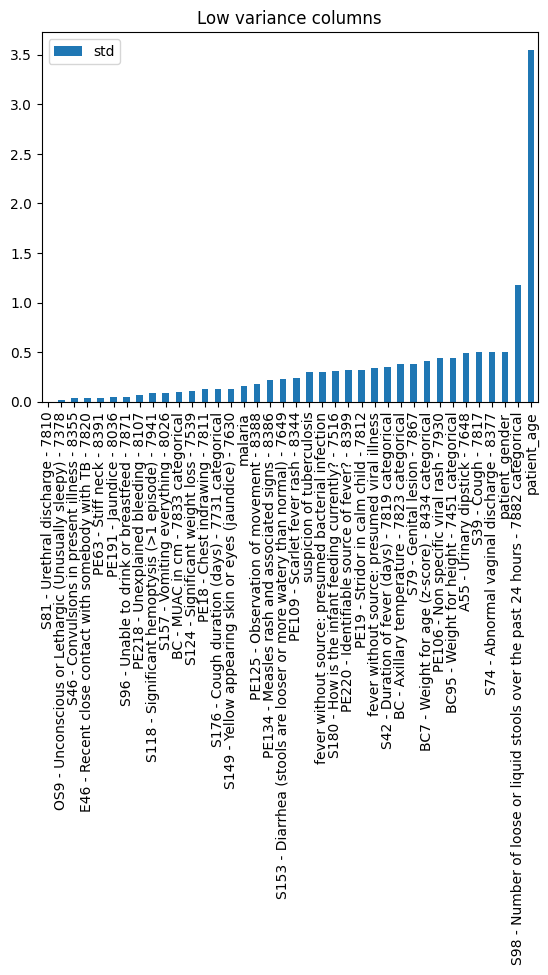

In [66]:
# plot low variance columns
var_rw_data[var_rw_data["std"] <= low_var_threshold].plot(kind="bar", rot=90, title="Low variance columns")

### "Low variance" in binary columns

In [67]:
# get binary and categorical features
binary_features_names = list(data.nunique(dropna=True).loc[lambda x : x <= 2].index)
binary_and_categorical_features_names = binary_features_names + categorical_features
binary_and_categorical_data = data[binary_and_categorical_features_names]

# count 1s and NaN values in each binary column
summary_binary_features = pd.DataFrame({"count_1s" : binary_and_categorical_data.sum(), "count_nan" : (binary_and_categorical_data.isna()*1).sum()})
summary_binary_features["n"] = binary_and_categorical_data.shape[0] #add number of observations for each feature (including nan)
summary_binary_features["share_1s"] = summary_binary_features["count_1s"] / (summary_binary_features["n"] - summary_binary_features["count_nan"])
summary_binary_features

,count_1s,count_nan,n,share_1s
patient_gender,25266.0,0,47886,0.527628
S39 - Cough - 7817,17664.0,15831,47886,0.551053
PE18 - Chest indrawing - 7811,291.0,30425,47886,0.016666
S46 - Convulsions in present illness - 8355,40.0,14943,47886,0.001214
BC - Axillary temperature - 7823 categorical,6290.0,12798,47886,0.179264
S96 - Unable to drink or breastfeed - 7871,86.0,16325,47886,0.002725
S157 - Vomiting everything - 8026,242.0,16324,47886,0.007667
OS9 - Unconscious or Lethargic (Unusually sleepy) - 7378,12.0,16324,47886,0.000380
PE63 - Stiff neck - 8391,14.0,40100,47886,0.001798
PE19 - Stridor in calm child - 7812,113.0,46896,47886,0.114141


## Missingness

In [68]:
# share of nan per feature
nnan_data = data.isnull().sum(axis = 0).to_frame(name="nnan").sort_values("nnan", ascending=False)
nnan_data["nnan_share_in_%"] = nnan_data["nnan"] / data.shape[0] * 100
nnan_data

,nnan,nnan_share_in_%
S81 - Urethral discharge - 7810,47878,99.983294
S79 - Genital lesion - 7867,47857,99.939440
S74 - Abnormal vaginal discharge - 8377,47646,99.498810
fever without source: presumed bacterial infection,47297,98.769995
fever without source: presumed viral illness,47103,98.364867
PE218 - Unexplained bleeding - 8107,47103,98.364867
A55 - Urinary dipstick - 7648,47002,98.153949
PE19 - Stridor in calm child - 7812,46896,97.932590
S118 - Significant hemoptysis (>1 episode) - 7941,46811,97.755085
PE125 - Observation of movement - 8388,46489,97.082655


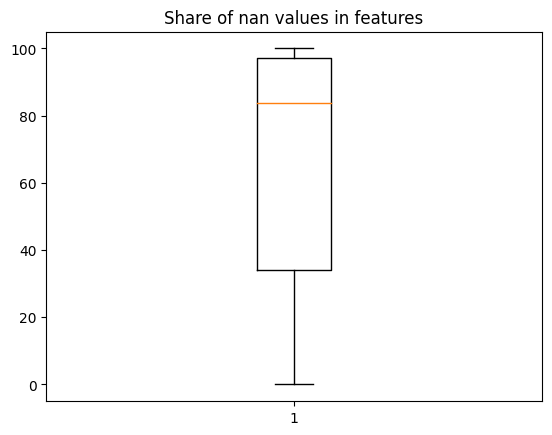

In [69]:
# boxplot of share of nan values in feautures
plt.boxplot(nnan_data["nnan_share_in_%"])
plt.title("Share of nan values in features")
plt.show()

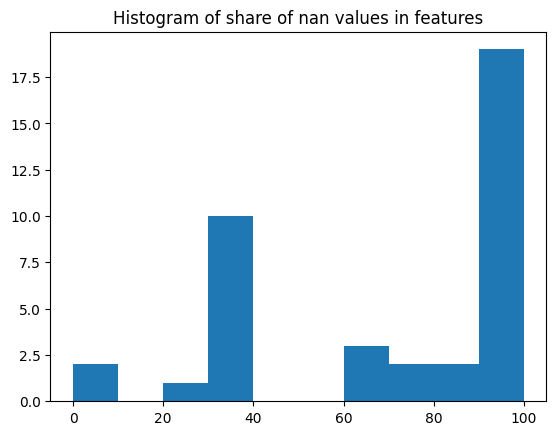

In [70]:
# distribution of share of nan values in features
plt.hist(nnan_data["nnan_share_in_%"])
plt.title("Histogram of share of nan values in features")
plt.show()

In [71]:
# columns with no nan
print(nnan_data[nnan_data["nnan"] == 0].size/nnan_data.size*100, "%", "of columns contain no NaN values!")
nnan_data[nnan_data["nnan"] == 0].index

5.128205128205128 % of columns contain no NaN values!


Index(['patient_gender', 'patient_age'], dtype='object')

94.87179487179486 % of columns contain less or equal than 99.9 % of NaN values!


<AxesSubplot:title={'center':'Columns with less or equal than 99.9% of NaN values'}>

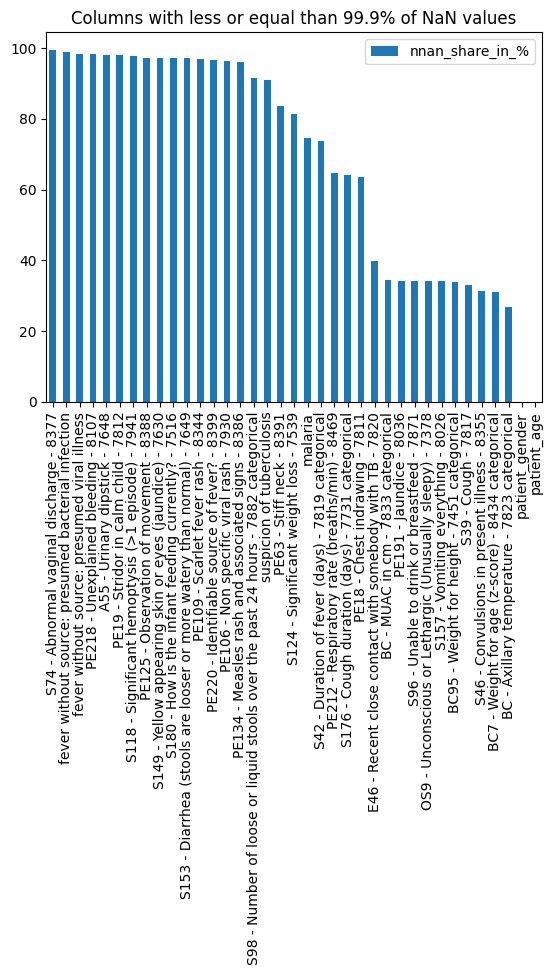

In [72]:
# plot columns with acceptable amount of NaN values
nnan_threshold = 99.9 # in % (NOTE: all features with more than nnan_threshold nan values will be removed in data cleaning section)
print(nnan_data[nnan_data["nnan_share_in_%"] <= nnan_threshold].shape[0] / nnan_data.shape[0] * 100, "%", "of columns contain less or equal than", nnan_threshold,"%", "of NaN values!")
nnan_data[nnan_data["nnan_share_in_%"]  <= nnan_threshold].plot(kind="bar", y="nnan_share_in_%", rot=90, title=f"Columns with less or equal than {nnan_threshold}% of NaN values")

# Chosing features

In [73]:
# drop columns with too many NaN values based on nnan_threshold and store them as features
features = data[nnan_data[nnan_data["nnan_share_in_%"]  <= nnan_threshold].index]

# print number of final features and how many nan values they contain
print("number of final features:", len(features.columns))
print("number of dropped features:", len(data.columns) - len(features.columns))
print("total amount of nan values accross features:", features.isna().sum().sum())

# print list of columns dropped because of this cleaning step
print("columns used as features:", [f for f in data.columns if f not in features.columns])

number of final features: 37
number of dropped features: 2
total amount of nan values accross features: 1205808
columns used as features: ['S81 - Urethral discharge - 7810', 'S79 - Genital lesion - 7867']


# Missingness pattern in features - MCAR, MAR or MNAR?
- MCAR = Missing completely at random = missingness of values of a certain feature depends not on any data
- MAR = Missing at random = missingness of values of a certain feature depends on given values of other features (e.g. symptom1 is missing data when there are high values of symptom2 given.)
- MNAR = Missing not at random = missingness of values of a certain feature depends the not given data of the feature itself (e. g. symptom1 misses data whenever symptom1 would have low values. However, these low values are never observed.)

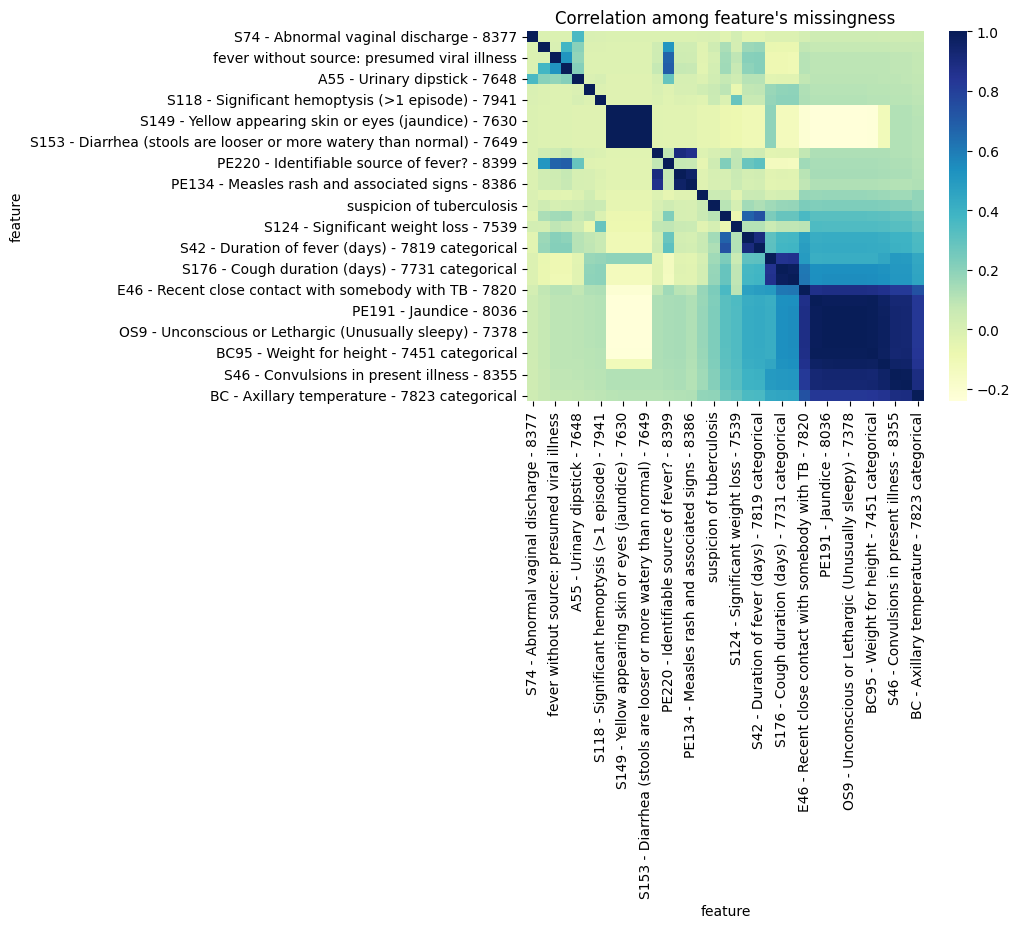

In [74]:
# shadow matrix: whenever original features holds nan value the missingness matrix will have a 1 at this element position else 0
shadow_matrix_features = features.isna()*1

# check if missingness of features correlates with other features' missingness
missingness_correlation = shadow_matrix_features.corr().dropna(how = "all").dropna(how = "all", axis = 1) # drop rows and columns which entirely consist of nan

# visualize correlation of features' missingness
missingness_correlation_heatmap = sb.heatmap(missingness_correlation, cmap="YlGnBu", annot=False)
plt.title("Correlation among feature's missingness")
plt.xlabel("feature")
plt.ylabel("feature")

# displaying heatmap
plt.show()

In [75]:
# check for multicollinearity: is given if VIF (= variance inflation factor) is high (usually if vif > 3) source: https://www.investopedia.com/terms/v/variance-inflation-factor.asp#:~:text=A%20variance%20inflation%20factor%20(VIF)%20is%20a%20measure%20of%20the,in%20a%20multiple%20regression%20model.
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = shadow_matrix_features.columns
vif['VIF'] = [variance_inflation_factor(shadow_matrix_features.values, i) for i in range(shadow_matrix_features.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

c:\Users\sidla\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\Users\sidla\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,Features,VIF
28,OS9 - Unconscious or Lethargic (Unusually slee...,inf
10,S153 - Diarrhea (stools are looser or more wat...,inf
29,S157 - Vomiting everything - 8026,inf
8,S149 - Yellow appearing skin or eyes (jaundice...,inf
9,S180 - How is the infant feeding currently? - ...,inf
27,S96 - Unable to drink or breastfeed - 7871,16758.66
7,PE125 - Observation of movement - 8388,9341.90
13,PE106 - Non specific viral rash - 7930,464.09
26,PE191 - Jaundice - 8036,378.64
30,BC95 - Weight for height - 7451 categorical,338.46


## Takeaways
- There are several correlations among the features's missingness. One example would be `PE217 - Severe difficult breathing needing referral - 8398` and `PE133 - Grunting - 8393` with a correlation coefficient of 1, meaning that whenever data is missing for one feature the other feature misses data too. This is an indicator for missing at random because missingness of a feature can be explained by the given data of another feature. 
- One can say that since nearly every feature correlates at least with one other feature the data is mostly missing at random. Only few features are missing clompletely at random e.g. `PE214`. The VIF scores confirms this once again.

# Preparing features for cluster
Considering the gained insights on the data from before, we have the following issues we need to address before to get a meaningful K-Means clustering
- K-Means assumes spherical shape of data although the shape of our highly dimensional data is unknown.
- K-Means struggles with high dimensional data. Like many other clustering algorithms, k-means clustering starts to struggle when many features are included in the model. If you have many potential features, you should consider applying feature selection or dimensionality reduction algorithms to your data before creating your clusters.
- Difficult to incorporate categorical variables. As is common with many clustering algorithms, k-means is intended for situations where all of your features are numeric. As such, it does not perform as well in cases where you need to incorporate categorical features in your dataset.
- K-Means is sensitive to scale so continues features with higher scale than the majority of binary/categorical features will have an outsized effect on the distance calculated.

[source](https://crunchingthedata.com/when-to-use-k-means-clustering/#:~:text=One%20of%20the%20main%20disadvantages,clusters%20naturally%20have%20irregular%20shapes.)

# Clustering
In the following the previously selected and cleaned features are clustered. Since the underlying data comes from CDSS, a lot of NAN values are systematically present. To address this, there will be diverse clustering runs:
1. K-Means clustering of raw features with NAN values TODO
2. K-Means clustering of the features containing no NAN values (zero NAN tolerance)
3. K-Means clustering of all features with imputed values (mean for continues features and median for categorical features)
4. K-Means clustering of all features with imputed values and an indicator variable - an additional binary feature to track the imputed values for each feature
5. K-Means clustering of all features with domain based imputed values (NAN == 0 as NAN means question skipped or not answered by the medical field worker, hence the symptom/feature was not present, for continues variables with NAN we use the median)

Please note, that K-Means is chosen for clustering whenever applicable due to experience from previous work on clustering CDSS data at IGH. 
    

cluster three datasets different regarding how missingness is addressed
        1. symptom and demographic data with NAN values --> use kmeans variation that handles NAN (kmeans++ or fuzzy clustering or GMM)
        2. impute NAN as if missingness is at random: use mean for continues and median for binary
        3. impute NAN as above. however, we also always add a binary column keeping track if value of respective feature is imputed or not --> analyse if imputation is picked up by clusters

In [76]:
!pip install yellowbrick


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

## Clustering of raw features (with NAN values)
Mahalanobis distance is used since it can handle NAN values. It is defined as the distance between two points, x and y, in a multivariate space, normalized by the variance-covariance matrix of the dataset, i. e. it is the Euclidian distance weighted by the inverse of the variance-covariance matrix. This means that features that have a high variance (i.e., that are more spread out) will have less weight in the distance computation than variables with low variance.

In [78]:
if False: 
    from sklearn.covariance import EmpiricalCovariance
    from sklearn.metrics.pairwise import pairwise_distances

    # Compute the covariance matrix using the available data
    cov = EmpiricalCovariance().fit(features[np.isfinite(features).all(axis=1)])

    # Compute the Mahalanobis distance matrix using the covariance matrix
    mahalanobis_dist = pairwise_distances(features, metric='mahalanobis', VI=np.linalg.inv(cov.covariance_))

    # Perform k-means clustering with k=3
    kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
    kmeans.fit(mahalanobis_dist)

    # Print cluster assignments for each observation
    print(kmeans.labels_)

In [79]:
if False:
    #  TODO try out kmeans with Gower distance or the Mahalanobis distance
    from sklearn.metrics.pairwise import pairwise_distances


    # Compute Gower distances
    gower_dist = pairwise_distances(features, metric='mahalanobis')
    print(gower_dist.shape)

    # Perform k-means clustering with k=3
    kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
    kmeans.fit(gower_dist)

    # Print cluster assignments for each observation
    print(features.shape)
    print(kmeans.labels_)

In [80]:
if False:
    !pip install scikit-learn-extra

In [81]:
if False:
    from sklearn_extra.cluster import KMedoids

    # Finding the optimal number of clusters using the Elbow method with yellowbrick
    model = KMedoids(n_init =10)
    visualizer = KElbowVisualizer(model, k=(1,11))
    visualizer.fit(features)
    n_clusters = visualizer.elbow_value_ # optimal number of clusters
    visualizer.show()

In [82]:
if False:
    # Performing clustering with the optimal number of clusters
    kmoids = KMedoids(n_clusters=n_clusters, n_init=10, random_state=0).fit(features)

    # Adding the column 'cluster' to the dataframe
    features_raw = features
    features_raw["cluster"] = kmoids.labels_

In [83]:
if False:
    !pip install kmodes

In [84]:
if False:
    # Initialize the KModes algorithm with 3 clusters and let it automatically detect categorical features
    kmodes = KModes(n_clusters=3)
    clusters = kmodes.fit_predict(features, categorical=None, missing='value')

    # Get the cluster centroids and the column indices of the categorical features
    centroids = kmodes.cluster_centroids_
    cat_cols = np.unique(np.where(np.isnan(centroids))[1])

In [85]:
if False:
    from kmodes.kprototypes import KPrototypes
    from kmodes.kmodes import KModes

    # Compute the  within-cluster sum of squaresWCSS for different numbers of clusters
    # TODO filter for "nan" in the doc https://kprototypes.readthedocs.io/_/downloads/en/latest/pdf/
    wcss = []
    for i in range(1, 11):
        kproto = KPrototypes(n_clusters=i) #, categorical=cat_cols
        kproto.fit(features, missing='value')
        wcss.append(kproto.cost_)

    # Plot the WCSS results
    plt.plot(range(1, 11), wcss)
    plt.title("Elbow Method")
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

## K-Means clustering of the features containing no NAN values

In [86]:
# Retrieve all features with no nan value
features_no_nan = features.dropna(axis=1)
print("Dropping columns with NAN, leads to", features.shape[1]-features_no_nan.shape[1],"less columns.")
print(features_no_nan.shape[1], "columns are used for clustering, which are:")
for col in features_no_nan.columns:
    print(col)

Dropping columns with NAN, leads to 35 less columns.
2 columns are used for clustering, which are:
patient_gender
patient_age


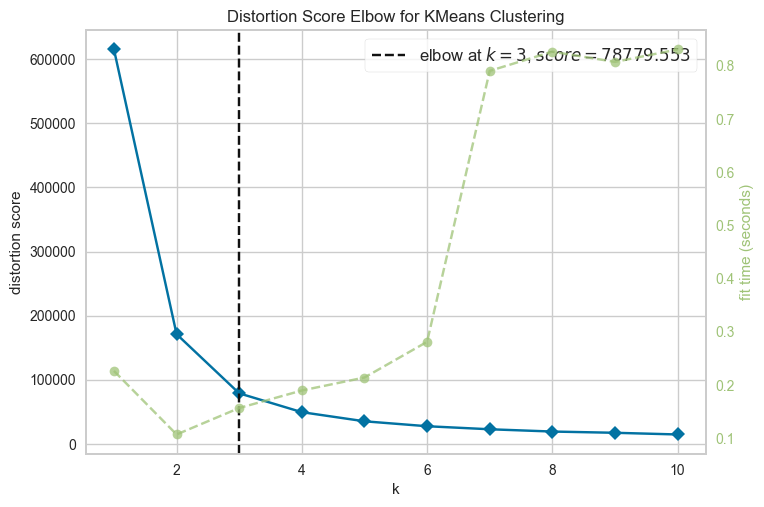

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [87]:
# Finding the optimal number of clusters using the Elbow method with yellowbrick
model = KMeans(n_init =10)
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(features_no_nan)
n_clusters = visualizer.elbow_value_ # optimal number of clusters
visualizer.show()

In [88]:
# Performing clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(features_no_nan)

# Adding the column 'cluster' to the dataframe
features_no_nan["cluster"] = kmeans.labels_

C:\Users\sidla\AppData\Local\Temp\ipykernel_7492\3283319560.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_no_nan["cluster"] = kmeans.labels_


<AxesSubplot:title={'center':'Number of consultations per cluster'}, xlabel='cluster'>

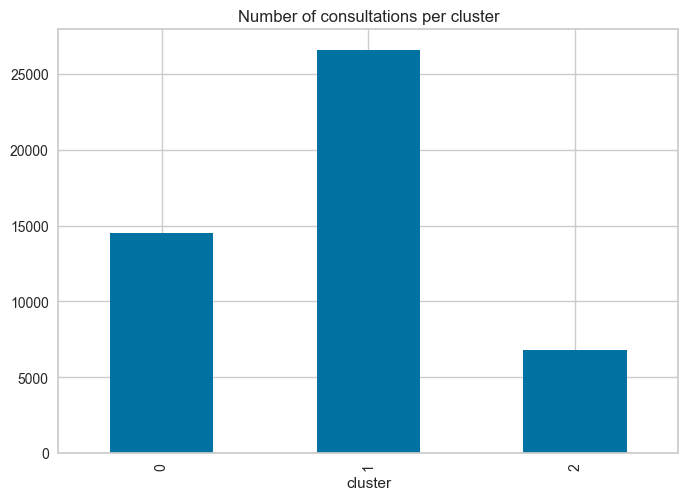

In [89]:
features_no_nan.groupby("cluster").size().plot(kind="bar", title="Number of consultations per cluster")

## K-Means with imputed features

In [90]:
imputed_features = features.copy(deep=True)

In [91]:
# impute binary columns with median
for binary_col in list(imputed_features.nunique(dropna=True).loc[lambda x : x <= 2].index) + categorical_features:
    imputed_features[binary_col].fillna(imputed_features[binary_col].median(), inplace=True)

In [92]:
# impute continues variables with mean
# NOTE we assume all remaining features with NaN are not binary and thus continues
for nan_col in (imputed_features.isna()*1).sum().loc[lambda x : x != 0].index:
    imputed_features[nan_col].fillna(imputed_features[nan_col].mean(), inplace=True)

In [93]:
print("Before imputation:", features.isna().sum().sum(), "NAN values in", features.isna().sum().loc[features.isna().sum()>0].shape[0],"columns")
print("After imputation:", imputed_features.isna().sum().sum(), "NAN values in", imputed_features.isna().sum().loc[imputed_features.isna().sum()>0].shape[0],"columns")

Before imputation: 1205808 NAN values in 35 columns
After imputation: 0 NAN values in 0 columns


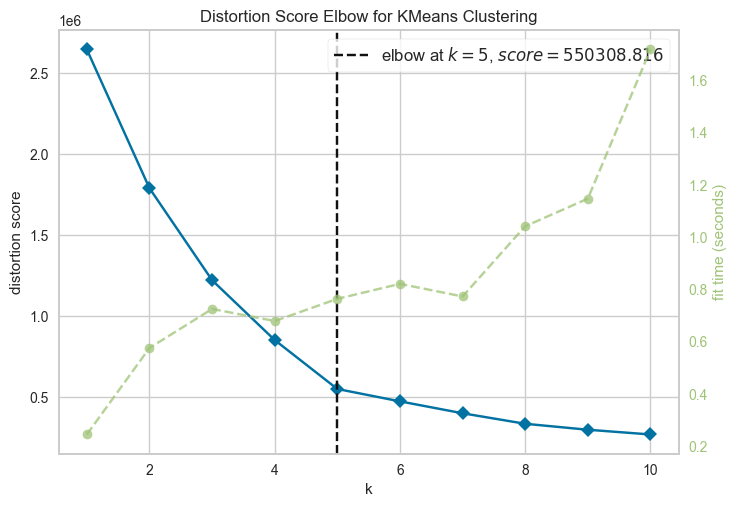

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [94]:
# Finding the optimal number of clusters using the Elbow method with yellowbrick
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(imputed_features)
n_clusters = visualizer.elbow_value_ # optimal number of clusters
visualizer.show()

In [95]:
# Performing clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(imputed_features)

# Adding the column 'cluster' to the dataframe
imputed_features["cluster"] = kmeans.labels_

<AxesSubplot:title={'center':'Number of consultations per cluster'}, xlabel='cluster'>

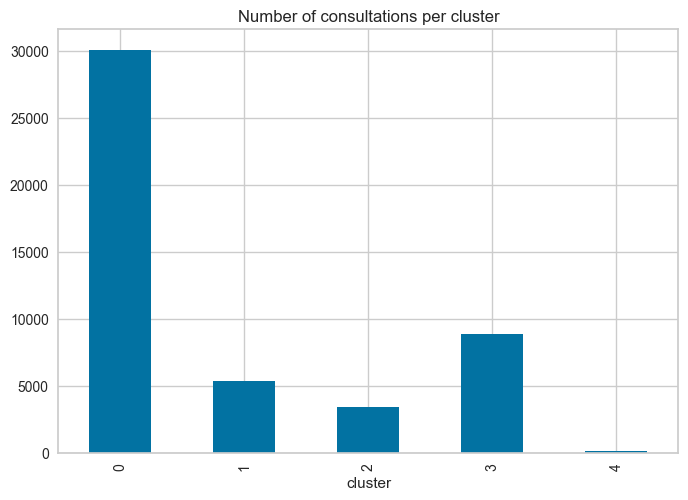

In [96]:
imputed_features.groupby("cluster").size().plot(kind="bar", title="Number of consultations per cluster")

## K-Means clustering with imputed features and indication variable

In [97]:
indicated_imputed_features = features.copy(deep=True)

In [98]:
# impute binary columns with median
for binary_col in indicated_imputed_features.nunique(dropna=True).loc[lambda x : x <= 2].index:
    if indicated_imputed_features[binary_col].isna().sum() == 0:
        continue
    indicated_imputed_features["imputed_"+binary_col] = np.multiply(indicated_imputed_features[binary_col].isna(), 1)
    indicated_imputed_features[binary_col].fillna(indicated_imputed_features[binary_col].median(), inplace=True)


In [99]:
# impute continues variables with mean
# NOTE we assume all remaining columns are not binary and thus continues
for nan_col in indicated_imputed_features.isna().sum().loc[lambda x : x != 0].index:
    indicated_imputed_features["imputed_"+nan_col] = np.multiply(indicated_imputed_features[nan_col].isna(), 1)
    indicated_imputed_features[nan_col].fillna(indicated_imputed_features[nan_col].mean(), inplace=True)

In [100]:
print("Before imputation:", features.isna().sum().sum(), "NAN values in", features.isna().sum().loc[features.isna().sum()>0].shape[0],"columns")
print("After imputation:", indicated_imputed_features.isna().sum().sum(), "NAN values in", indicated_imputed_features.isna().sum().loc[indicated_imputed_features.isna().sum()>0].shape[0],"columns")

Before imputation: 1205808 NAN values in 35 columns
After imputation: 0 NAN values in 0 columns


In [101]:
indicated_imputed_features.columns

Index(['S74 - Abnormal vaginal discharge - 8377',
       'fever without source: presumed bacterial infection',
       'fever without source: presumed viral illness',
       'PE218 - Unexplained bleeding - 8107', 'A55 - Urinary dipstick - 7648',
       'PE19 - Stridor in calm child - 7812',
       'S118 - Significant hemoptysis (>1 episode) - 7941',
       'PE125 - Observation of movement - 8388',
       'S149 - Yellow appearing skin or eyes (jaundice) - 7630',
       'S180 - How is the infant feeding currently? - 7516',
       'S153 - Diarrhea (stools are looser or more watery than normal) - 7649',
       'PE109 - Scarlet fever rash - 8344',
       'PE220 - Identifiable source of fever? - 8399',
       'PE106 - Non specific viral rash - 7930',
       'PE134 - Measles rash and associated signs - 8386',
       'S98 - Number of loose or liquid stools over the past 24 hours - 7882 categorical',
       'suspicion of tuberculosis', 'PE63 - Stiff neck - 8391',
       'S124 - Significant weigh

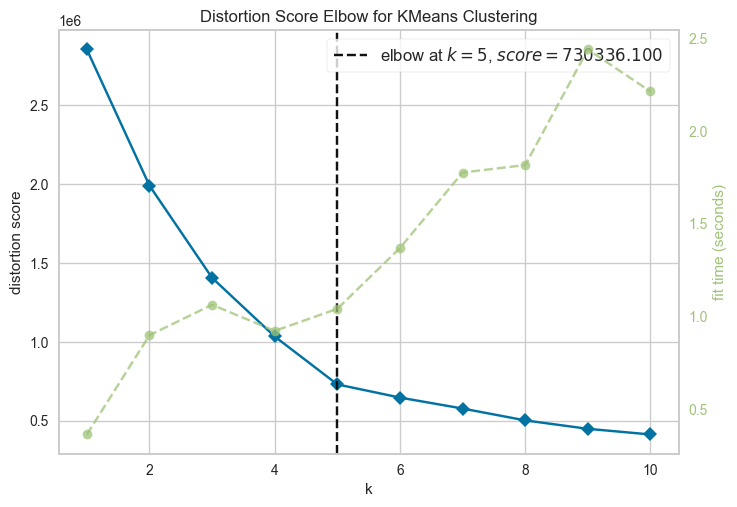

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [102]:
# Finding the optimal number of clusters using the Elbow method with yellowbrick
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(indicated_imputed_features)
n_clusters = visualizer.elbow_value_ # optimal number of clusters
visualizer.show()

In [103]:
# Performing clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(indicated_imputed_features)

# Adding the column 'cluster' to the dataframe
indicated_imputed_features["cluster"] = kmeans.labels_

<AxesSubplot:title={'center':'Number of consultations per cluster'}, xlabel='cluster'>

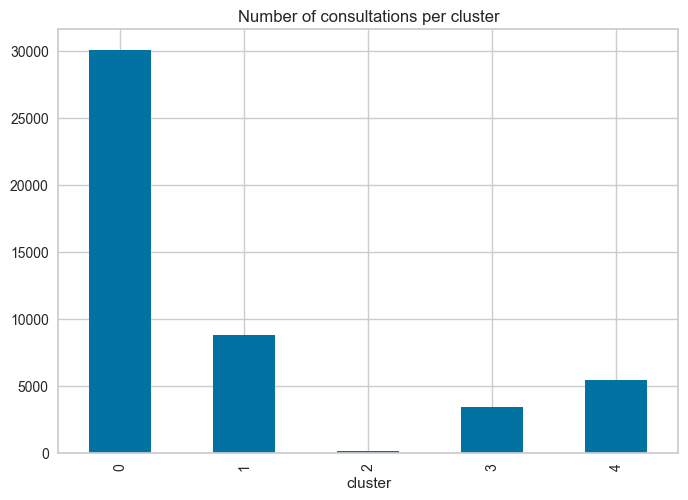

In [104]:
indicated_imputed_features.groupby("cluster").size().plot(kind="bar", title="Number of consultations per cluster")

## K-Means clustering with domain based imputed features
1. binary and categorical features: NAN = 0 (since NAN means clinician skipped or did not answer question because symptom is not there aka 0)
2. continues features: NAN = Median

Note: for some categorical features there is a difference between NAN and 0, e.g.:
-  for S176 - Cough duration (days) - 7731 categorical the original values are mapped like this: "< 2 weeks": 0,  ">= 2 weeks": 1.
However, there is a clear difference between NAN and having a cough "< 2 weeks". This is not accounted for in the algorithm.

In [105]:
domain_based_imputed_features = features.copy(deep=True)

In [106]:
# impute binary and categorical columns with 0
for binary_col in list(domain_based_imputed_features.nunique(dropna=True).loc[lambda x : x <= 2].index) + categorical_features:
    if domain_based_imputed_features[binary_col].isna().sum() == 0:
        continue
    domain_based_imputed_features[binary_col].fillna(0, inplace=True)


In [107]:
# impute continues with median
# NOTE we assume all remaining columns are not binary and thus continues
for nan_col in domain_based_imputed_features.isna().sum().loc[lambda x : x != 0].index:
    domain_based_imputed_features[nan_col].fillna(domain_based_imputed_features[nan_col].median(), inplace=True)

In [108]:
print("Before imputation:", features.isna().sum().sum(), "NAN values in", features.isna().sum().loc[features.isna().sum()>0].shape[0],"columns")
print("After imputation:", domain_based_imputed_features.isna().sum().sum(), "NAN values in", domain_based_imputed_features.isna().sum().loc[domain_based_imputed_features.isna().sum()>0].shape[0],"columns")

Before imputation: 1205808 NAN values in 35 columns
After imputation: 0 NAN values in 0 columns


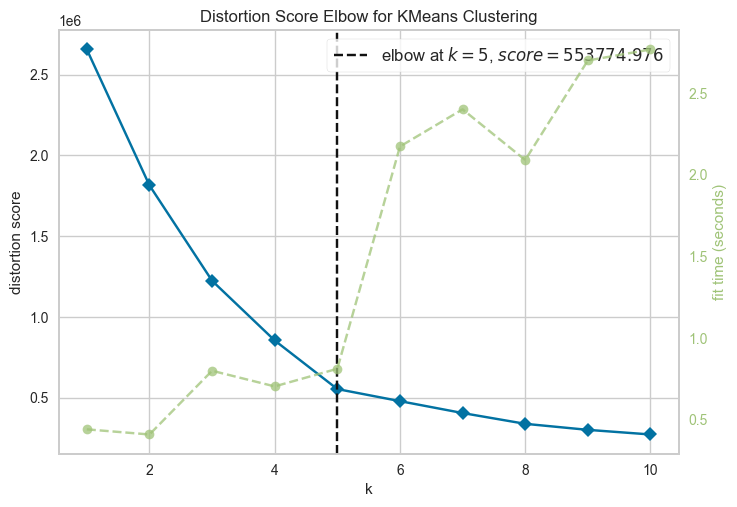

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [109]:
# Finding the optimal number of clusters using the Elbow method with yellowbrick
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(domain_based_imputed_features)
n_clusters = visualizer.elbow_value_ # optimal number of clusters
visualizer.show()

In [110]:
# Performing clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(domain_based_imputed_features)

# Adding the column 'cluster' to the dataframe
domain_based_imputed_features["cluster"] = kmeans.labels_

<AxesSubplot:title={'center':'Number of consultations per cluster'}, xlabel='cluster'>

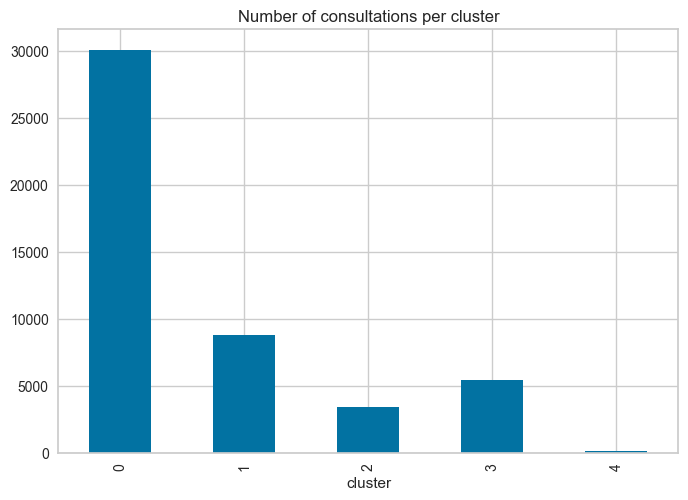

In [111]:
domain_based_imputed_features.groupby("cluster").size().plot(kind="bar", title="Number of consultations per cluster")

In [112]:
# store as pickle for dashboard
domain_based_imputed_features.to_pickle("data/domain_based_imputed_features.pickle")

# Quality check up of clustering results - which NAN preprocessing method gives best clustering result?
To decide which NAN preprocessing is best we consider the following points:
1. compare common metrics for assessing clustering results: silhouette score
2. Does missingness explain the clustering result?
    - if yes, the nan preprocessing method is bad cause these missing values have influence on the clustering. 
    - if not, it is good clustering result as it means that the nan preprocessing has similar effect on clustering as if the missing values were there 
    - (check this intuition with annie)
3. compare difference of clustering results: does NAN preprocessing method change the result?
    - how did consultations move between clusters of different clustering in a sankey graph?
    - analyse consultations which are assigned in different clusters depending on the clustering results --> TODO
4. compare feature distribution: a good clustering result ...
    - does not only use demographic features: age and gender to cluster
    - does not only cluster diagnoses as this project's aim is finding nuances: i. a. diagnosis missed by the CDSS
5.

In [113]:
# bundling of all clustering results depending on nan preprocessing method
cluster_datasets = [features_no_nan, imputed_features, indicated_imputed_features, domain_based_imputed_features]
nan_preprocess_method = ["removed NAN", "imputed NAN", "imputed NAN with indication", "domain based imputed NAN"]

## Rough overview of clustering result

In [ ]:
for i, cluster_data in enumerate(cluster_datasets):
    print("features if NAN preprocessing method"+nan_preprocess_method[i]+":", cluster_data.columns)

In [ ]:
x = "patient_age"
y = 'patient_gender' # "S39 - Cough - 7817"
for i, cluster_data in enumerate(cluster_datasets):
    fig = px.scatter(cluster_data, y=y, x=x, color="cluster", title = "result of clustering with "+nan_preprocess_method[i])
    fig.update_traces(marker_size=10)
    fig.show()

In [ ]:
#plot every feature combination and cluster result
"""for i, cluster_data in enumerate(cluster_datasets):
    sb.pairplot(cluster_data, hue="cluster")
    plt.suptitle("Pair plot of features per cluster - NAN preprocessing method: "+nan_preprocess_method[i], size = 28)"""

## Comparing common metrics

### Silhouette score
Silhouette score returns the average silhouette coefficient applied on all the samples. The Silhouette Coefficient is calculated by using the mean of the distance of the intra-cluster and nearest cluster for all the samples. 
- source: https://analyticsindiamag.com/a-tutorial-on-various-clustering-evaluation-metrics/

In [ ]:
from sklearn.metrics import silhouette_score
for i, cluster_data in enumerate(cluster_datasets):

    print("Clustering with NAN prprocssing method:", nan_preprocess_method[i])
    
    features_temp = cluster_data[cluster_data.columns[~cluster_data.columns.isin(["cluster"])]]
    silhouette_avg = silhouette_score(features_temp, cluster_data["cluster"])
    print("The average Silhouette score is :", silhouette_avg)

The Silhouette score is a metric that measures how well a data point fits into its assigned cluster, as compared to other clusters. It takes values between -1 and 1, where:

- A score of +1 indicates that the data point is far away from its neighboring clusters and is well-matched to its assigned cluster.
- A score of 0 indicates that the data point is close to the decision boundary between two clusters.
- A score of -1 indicates that the data point may have been assigned to the wrong cluster.

The Silhouette score can be used to evaluate the quality of a clustering solution, with higher scores indicating better cluster quality. However, it should be noted that a high Silhouette score does not necessarily mean that the clustering solution is optimal, as there may be other solutions with equally good or better scores. 

That being said, the clustering result of each NAN preprocessing method does not seem to differentiate each other by much in terms of the silhouette score. They all have a average silhouette score above 0.5 which is generally the lower-bound for silhouette scores of acceptable clustering. Imputing NAN with indication seems to bring the worst clustering result according to SIlhouette score.

## Qualitative quality check up: diagnoses distribution per cluster
Are we clustering more than just the diagnoses? If yes, then good and interesting as we have found groups of symptoms belonging to undiagnosed diseases. If not, then we have meaningless clustering since we just found the information in the diagnoses columns aka we found the decision tree of DYNAMIC's CDSS as a pattern through clustering aka we clustered for the branches of said tree.


In [ ]:
diagnoses_appearance_threshold = 10 # for binary diagnoses
raw_rw_diagnoses = rw_data[diagnoses_of_interest]
raw_rw_diagnoses = raw_rw_diagnoses.dropna(axis=1, how='all') # drop diagnoses which were not diagnosed once

# normalize: Accepted = 1, Rejected = 0, NAN = NAN, assume doctor's diagnosis = CDSS's diagnosis (= "Manually added": 1)
raw_rw_diagnoses = raw_rw_diagnoses.apply(lambda x : x.replace({"Accepted": 1, "Rejected": 0, "Manually added": 1}), axis=1) 

# merge diagnoses that are seperated over several columns 
# (e. g. DF9 - suspicion of tuberculosis – 30886, DF - suspicion of tuberculosis – 26232 are two columns for the same diagnosis)
list_diagnoses = [d.split(" - ")[1] for d in raw_rw_diagnoses.columns]
rw_diagnoses = raw_rw_diagnoses.groupby(list_diagnoses, axis=1, dropna=False).sum(min_count=1) #min_count=1 ensures that sum of only NAN is NAN and that same diagnoses are correctly merged

# summarize diagnoses used for further analysis
print("After cleaning and merging columns of the same diagnosis,", rw_diagnoses.shape[1], "diagnoses are considered. Before there were", raw_rw_diagnoses.shape[1], "diagnoses.")

# find diagnoses that were merged and summed together so that value is bigger than 1 (and thus not binary anymore)
for c in rw_diagnoses.columns:
    if(all(val < 2.0 for val in rw_diagnoses[c].unique())):
        print(c+":", rw_diagnoses[c].unique())
        
# check if all diagnoses are binary
binary_rw_diagnoses = rw_diagnoses.nunique(dropna=True).loc[lambda x : x <= 2].index
print("Percentage binary diagnoses:", len(binary_rw_diagnoses)/rw_diagnoses.shape[1])

# print non binary diagnosis
for non_binary_diagnosis in rw_diagnoses.loc[:, ~rw_diagnoses.columns.isin(binary_rw_diagnoses)].columns:
    print(non_binary_diagnosis+":", rw_diagnoses[non_binary_diagnosis].unique())

# add each clustering results to each diagnosed consultation (= rw_diagnoses df)
for i, cluster_data in enumerate(cluster_datasets):
    column_name = "cluster_"+nan_preprocess_method[i]
    rw_diagnoses[column_name] = cluster_data["cluster"]

In [ ]:
# plot for each clustering result the diagnoses distribution per cluster (due to binary diagnoses, we count and show top 10 diagnoses as bar plot)
for nan_method in nan_preprocess_method:
    temp = rw_diagnoses[list_diagnoses+["cluster_"+nan_method]].groupby("cluster_"+nan_method).sum().reset_index().melt(
                id_vars=["cluster_"+nan_method],
                var_name="diagnosis", 
                value_name="sum"
            ).drop_duplicates()

    # get top 10 most common diagnosis combinations (how many diagnoses are there per consultation/patient)
    temp_top_10_diagnoses_per_cluster = temp.sort_values(["cluster_"+nan_method, "sum"], ascending=False).groupby(["cluster_"+nan_method]).head(10)
    pd.pivot_table(temp_top_10_diagnoses_per_cluster,
                index="diagnosis", columns="cluster_"+nan_method, values="sum"
                ).plot(kind="bar", title="Diagnoses distribution per cluster for NAN preprocessing: "+nan_method)

In [ ]:
# plot percentage of top 10 diagnoses in cluster across all clusters for each nan preprocessing method
selected_diagnoses = ["common cold", "prevention and screening", "acute diarrhea", "non-severe abdominal condition"]

for nan_method in nan_preprocess_method:

    temp = rw_diagnoses[list_diagnoses+["cluster_"+nan_method]].groupby("cluster_"+nan_method).sum().reset_index().melt(
            id_vars=["cluster_"+nan_method],
            var_name="diagnosis", 
            value_name="sum"
        ).drop_duplicates()

    # compute percentage of selected diagnoses per cluster
    temp["percentage"] = temp["sum"] / temp.groupby("cluster_"+nan_method)["sum"].transform('sum')

    # sort by percentage and get top 10 diagnoses per cluster
    temp_top_10_diagnoses_per_cluster = temp.sort_values(["cluster_"+nan_method, "percentage"], ascending=False).groupby(["cluster_"+nan_method]).head(10)

    # get unique distinctive colors for each diagnosis
    list_colors = sb.color_palette("magma", n_colors=temp_top_10_diagnoses_per_cluster["diagnosis"].nunique())

    # create plot
    pd.pivot_table(
        data=temp_top_10_diagnoses_per_cluster, 
        index=["cluster_"+nan_method],
        columns=["diagnosis"], 
        values="percentage"
    ).plot(
        kind="bar", 
        title="Percentage of top 10 diagnoses per cluster of clustering with NAN preprocessing method: "+nan_method, 
        stacked=True,
        color=list_colors
    )
    plt.legend(loc="center right", bbox_to_anchor=(1.6, 0.5))


In [ ]:
!pip install networkit

In [ ]:
import networkit as nk
nan_method = 'domain based imputed NAN'
net_data = rw_diagnoses[list_diagnoses]
net_data

In [ ]:

# nodes = consultations, edges = diagnosis (if both consultations have the same diagnosis, weight = column idx of net_data)
diagnoses_consultations_network = nk.Graph(net_data.shape[0], weighted=True, directed=False)

# add cluster belongingness of consultation = node as node attribute
clustrAttr = diagnoses_consultations_network.attachNodeAttribute("cluster", int)

# build network
nodes = []

# add nodes
for c in rw_diagnoses["cluster_"+nan_method]:
    node = diagnoses_consultations_network.addNode()
    clustrAttr[node] = c
    nodes.append(node)

# a 
for i_diagnosis, col in enumerate(net_data.columns):
  #get consultation idx which got the same diagnosis = col
  idx_nodes = [i for i, con in enumerate(net_data[col]) if con == 1.0]

  for i in idx_nodes:
    for i2 in idx_nodes:
      if i == i2:
        continue
      else:
        diagnoses_consultations_network.addEdge(i, i2, w=i_diagnosis) # add edge with idx of columns = diagnosis as weights

nk.viztasks.drawGraph(diagnoses_consultations_network)

In [ ]:
nk.vizbridges.widgetFromGraph(diagnoses_consultations_network)

### Dimension reduction and analysis of diagnoses

In [ ]:
from sklearn.decomposition import PCA

for i, cluster_data in enumerate(cluster_datasets):
    title = "PCA visualization of clustering with NAN preprocessing: " + nan_preprocess_method[i]
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(cluster_data.loc[:, cluster_data.columns != "cluster"])

    
# TODO add for loop and add symbol=cluster_data[diagnosis] to scatter px functon 
# whereas diagnosis comes from lst of diagnoses that are the most prevelent once 
# accross all clusters for each nan preprocessing method
    fig = px.scatter(x=X_pca[:, 0], y=X_pca[:, 1], color=cluster_data["cluster"])
    fig.update_layout(
        title=title,
        xaxis_title="First Principal Component",
        yaxis_title="Second Principal Component",
    )
    fig.show()

In [ ]:
from sklearn.manifold import TSNE

tsne_results = []

for i, cluster_data in enumerate(cluster_datasets):
    
    tsne = TSNE(n_components=2, random_state=42*i) # TODO think about changing perplexity attribute to K used for kmeans aka max value in cluster_data["cluster"].unique().max()
    X_tsne = tsne.fit_transform(cluster_data.loc[:, cluster_data.columns != "cluster"])
    print("KL divergence:", tsne.kl_divergence_,"(for clustering with", nan_preprocess_method[i],")")
    
    tsne_results.append({"preprocessing_method_id":i, "kl_divergence":tsne.kl_divergence_, "X_tsne":X_tsne})
    

In [ ]:
for tsne_result in tsne_results:

    # plot clustering result in reduced space by TSNE
    title = "t-SNE visualization of clustering with NAN preprocessing: " + nan_preprocess_method[tsne_result["preprocessing_method_id"]]
    data = pd.DataFrame({
        "first_tSNE": tsne_result["X_tsne"][:, 0],
        "second_tSNE": tsne_result["X_tsne"][:, 1],
        "cluster": cluster_datasets[tsne_result["preprocessing_method_id"]]["cluster"]
    })
    fig = px.scatter(
        data,
        x="first_tSNE", 
        y="second_tSNE", 
        color="cluster"
    )
    
    fig.update_layout(
        title=title,
        #xaxis_title="First t-SNE",
        #yaxis_title="Second t-SNE",
    )
    fig.show()

    # plot clustering result in reduced space by TSNE with selected diagnoses
    for diagnosis in selected_diagnoses:
        title = "diagnosis '"+diagnosis+"' in clustering with NAN preprocessing: " + nan_preprocess_method[tsne_result["preprocessing_method_id"]]

        data[diagnosis]=rw_diagnoses[diagnosis]

        fig = px.scatter(
            data,
            x="first_tSNE", 
            y="second_tSNE", 
            color="cluster",
            facet_col=diagnosis
        )
        
        fig.update_layout(
            title=title,
            #xaxis_title="First t-SNE",
            #yaxis_title="Second t-SNE",
            #coloraxis_colorbar=dict(yanchor="top", y=1, x=0, ticks="outside")
            #colorbar=dict(title=diagnosis)
        )
        #fig.update_traces(
         #   marker=dict(size=12,
          #      line=dict(width=2,
           #     color='DarkSlateGrey')),
            #selector=dict(mode='markers')
        #)
        fig.show()

## Robustness
1. Bootstrap resampling: This involves randomly resampling the original dataset with replacement to create multiple bootstrap samples. Clustering is then performed on each of these samples, and the resulting clusters are compared to see how stable they are across the different samples. If the clustering solution is robust, the resulting clusters should be similar across the different bootstrap samples.

2. K-fold cross-validation: This involves splitting the original dataset into k equal-sized folds, and then performing clustering on k-1 folds and evaluating the resulting clusters on the remaining fold. This process is repeated k times, with each fold serving as the test set once. The resulting clusters are then compared across the different iterations to see how stable they are. If the clustering solution is robust, the resulting clusters should be similar across the different folds.

3. Sensitivity analysis: This involves varying the parameters of the clustering algorithm (such as the number of clusters or the distance metric) and evaluating the resulting clusters. If the clustering solution is robust, the resulting clusters should be relatively stable across different parameter values.

4. Visual inspection: This involves visually inspecting the resulting clusters and looking for any patterns or outliers that may indicate problems with the clustering solution. For example, if there are a few data points that consistently get assigned to different clusters across different runs of the clustering algorithm, this may indicate a problem with the clustering solution.

In [ ]:
# TODO

# Summary of clusters

## Basic stats of all features in clusters for each clustering result depending on NAN preprocessing method

In [ ]:
for i, cluster_data in enumerate(cluster_datasets):

    # print nan preprocessing method
    print("clustering with NAN preprocessing method:", nan_preprocess_method[i])

    # summarize each cluster's features
    for cluster in np.sort(cluster_data["cluster"].unique()):
        print("cluster:", cluster)

        # filter for cluster
        selected_cluster_data = cluster_data[cluster_data["cluster"] == cluster]

        # get features
        features_selected_cluster = selected_cluster_data.loc[:, selected_cluster_data.columns != "cluster"]

        # summarise features of selected cluster
        print(features_selected_cluster.describe())
        print()

    # for better overview in output
    print()
    print()

In [ ]:
for i, cluster_data in enumerate(cluster_datasets):

    title = "clustering with NAN preprocessing method: " + nan_preprocess_method[i]

    features_temp = cluster_data.columns != "cluster"

    # trying this: https://stats.stackexchange.com/questions/520731/how-to-plot-binary-vs-categorical-nominal-data
    binary_features_names_temp = cluster_data.nunique().loc[lambda x : x <= 2].index.tolist() # TODO change so that categorical features are captured when binary are captured too
    binary_and_categorical_data_temp = cluster_data[binary_features_names_temp + ["cluster"]]
    non_binary_and_categorical_data_temp = cluster_data.loc[:, ~cluster_data.columns.isin(binary_features_names_temp)]

    # summarize each cluster's features
    for binary_feature in [True, False]:
        if binary_feature:
            binary_and_categorical_data_temp.melt(
                id_vars=["cluster"],
                var_name="feature", 
                value_name="value"
            ).pivot_table(
                index="feature", 
                columns="cluster", 
                values="value", 
                aggfunc=np.mean
            ).plot(
                kind="bar", 
                ylabel="Mean",
                title = title + " - binary features"
            )
        else: 
            non_binary_and_categorical_data_temp.melt(
                id_vars=["cluster"],
                var_name="feature", 
                value_name="value"
            ).pivot_table(
                index="feature", 
                columns="cluster", 
                values="value", 
                aggfunc=np.mean
            ).plot(
                kind="bar", 
                ylabel="Mean",
                title = title + " - non-binary features"
            )

### Analysis of symptoms
- symptom distribution per cluster
- symptom appearing often together in patient --> where are these paired symptoms in the clusters

In [ ]:
# count how many consultations have the same symptom pair
existing_symptoms = [symp for symp in cluster_datasets[3].columns if symp in symptoms_of_interest]
symptom_pairs = pd.DataFrame(index=existing_symptoms, columns=existing_symptoms)

for col1 in symptom_pairs.columns:
    for col2 in symptom_pairs.columns:
        # Find the number of rows where both columns have the value 1
        count = ((cluster_datasets[3][col1] == 1) & (cluster_datasets[3][col2] == 1)).sum()
        symptom_pairs.loc[col1, col2] = count

symptom_pairs = symptom_pairs.astype(int)

In [ ]:
# Plot symptom_pairs as heatmap
plt.figure(figsize=(30, 30))
sb.heatmap(symptom_pairs, annot=True, cmap='YlGnBu')
plt.title('Number of patients with both symptoms')
plt.show()

In [ ]:
!pip install networkit

In [ ]:
symptom_count_per_cluster = cluster_datasets[3].groupby("cluster")[existing_symptoms].sum()
symptom_count_per_cluster 

In [ ]:
import networkit as nk

# creat ntwork
symptom_network = nk.Graph(n=len(existing_symptoms), weighted=True, directed=False) #-1 because "cluster" column should not count
nodes = []
edges = []

# add attr
nameAttr = symptom_network.attachNodeAttribute("name", str)

# add nodes
for symp in existing_symptoms:
    node = symptom_network.addNode()
    nameAttr[node] = symp
    nodes.append(node)

# add edges
#symptom_count_per_cluster = cluster_datasets[3].groupby("cluster")[existing_symptoms].sum()
for node in nodes:
    symp = nameAttr[node]
    for node_end in nodes:
        symp_end = nameAttr[node_end]
        if symp == symp_end:
            continue
        else:
            for 
                symptom_network.addEdge()
    

nk.viztasks.drawGraph(symptom_network)

## Analysis of missingness in clusters for each clustering result depending on NAN preprocessing method
To do so...
1. count features' missing values per cluster for each NAN preprocessing method
2. use logistic regression to identify if missing values explain the label. If yes, it means that if the values were not missing it might be a different clustering result.

In [ ]:
for i, cluster_data in enumerate(cluster_datasets):

    title = "clustering with NAN preprocessing method: " + nan_preprocess_method[i]
    
    # shadow matrix: whenever original features holds nan value the shadow matrix will have a 1 at this element position else 0
    shadow_matrix_temp = shadow_matrix_features
    shadow_matrix_temp["cluster"] = cluster_data["cluster"]

    # get unique distinctive colors for each diagnosis
    list_colors = sb.color_palette("magma", n_colors=shadow_matrix_features.shape[1])

    # group by cluster and count missing values
    shadow_matrix_temp.groupby("cluster").sum().plot(
        kind="bar", 
        title=title + " - sum NAN values per cluster", 
        #subplots=True, 
        #sort_columns=True,
        stacked=True,
        color=list_colors
    )
    plt.legend(loc="center right", bbox_to_anchor=(2, 0.5))

### Takeaways
- the number of nan values from the original features in each cluster signifies something different for each clustering result depending on NAN preprocessing method:
    - "CLUSTERING WITH NO NAN VALUES": number of nan-values per feature = number of observations per feature which missed for clustering decision
    - "CLUSTERING WITH IMPUTED VALUES" number of nan-values per feature = number of imputations per features
    - "CLUSTERING WITH IMPUTED VALUES AND AN EXTRA BINARY COLUMN FOR TRACKING IMPUTATION" number of nan-values per feature = number of imputations per feature and sum of indicated column of respectively imputed feature
- for each NAN preprocessing method it seems that the cluster with the most NAN values in total also contains the most missing values for each feature respectively (analog is the case for the cluster with least missing values). One thus can draw that missingness of each feature has an impact on the clustering decision

## Missingness as a *significant* explanation for clustering decision per cluster of each clustering result depending on NAN preprocessing
To do so, logistic regression is run on every cluster for each clustering result with shadow matrix as input and a binary output which informs whether consultation is part of respective cluster or not
    - while doing so dependent variables are checked for perfect separation, i. e. are there dependent variables which perfectly explain the output? 

In [ ]:
import statsmodels.api as sm

# variables to store results
mths = [] # method
clustrs = [] # cluster
fts = [] # feature
coefs = [] # coeffient of feature for explaining cluster label
pvals = [] # p-value of feature's coefficient

# perform binary logistic regression for each clustering results' clusters: does missingness explain the class label
for i, cluster_data in enumerate(cluster_datasets):

    # perform logistic regression for each cluster with shadow matrix as input
    for cluster in np.sort(cluster_data["cluster"].unique()):

        # make cluster column binary: 1 means that consultation is part of respective cluster and 0 not
        y = [1 if label == cluster else 0 for label in cluster_data["cluster"]]

        # check for perfect separation between features in shadow matrix and output y
            #perfect_features = []
            #for feature in shadow_matrix_features.columns:
                #if pd.Series(y).equals(shadow_matrix_features[feature]):
                    #perfect_features.append(feature)
            #print("perfectly separated features for cluster:", perfect_features)

        # remove perfectly separated features to avoid conversion issues
            #cleaned_shadow_matrix_features = shadow_matrix_features.loc[:, ~shadow_matrix_features.columns.isin(perfect_features)]
            #print("log regression with features:", shadow_matrix_features.columns)

        # perform logistic regression for each feature in the shadow matrix : does missingness explain the cluster label? yes, if p-values are high
        for ft in shadow_matrix_features:
            try:
                log_reg = sm.Logit(y, shadow_matrix_features[ft]).fit() #method='bfgs' essential to avoid SingleMatrix error
                
                # store results
                fts.append(ft)
                clustrs.append(cluster)
                mths.append(nan_preprocess_method[i])
                coefs.append(log_reg.params.values[0])
                pvals.append(log_reg.pvalues.values[0])
            except np.linalg.LinAlgError as err: #probably singular matrix error since feature is too sparse
                # store results
                fts.append(ft)
                clustrs.append(cluster)
                mths.append(nan_preprocess_method[i])
                coefs.append(np.nan)
                pvals.append(np.nan)

# store logistic regression results for each feature, cluster, method combi
effect_missingness_on_clustering = pd.DataFrame({"method":mths, "cluster":clustrs, "feature":fts, "coefficient":coefs, "p_value":pvals})

In [ ]:
# method, feature, cluster combis whose logistic regression failed due to singular matrix error
effect_missingness_on_clustering[effect_missingness_on_clustering["p_value"].isna()]

In [ ]:
# method, feature, cluster combis whose logistic regression cannot be trusted since p-value is 0
effect_missingness_on_clustering[effect_missingness_on_clustering["p_value"] == 0.0]

In [ ]:
# method, feature, cluster combis whose logistic regression can be trusted
effect_missingness_on_clustering[(effect_missingness_on_clustering["p_value"] != 0.0) & (~effect_missingness_on_clustering["p_value"].isna())]

In [ ]:
# method, feature, cluster combis whose logistic regression can be trusted and coefficients are significant
# i.e. feature's missingness explains cluster label if certain cleaning method is used
missingness_impacting_clustering = effect_missingness_on_clustering[(effect_missingness_on_clustering["p_value"] != 0.0) & (~effect_missingness_on_clustering["p_value"].isna()) & (effect_missingness_on_clustering["p_value"] <= 0.05)]
missingness_impacting_clustering = missingness_impacting_clustering[missingness_impacting_clustering["feature"] != "cluster"] # remove feature cluster since this is the label
missingness_impacting_clustering

In [ ]:
# count for each method how many clusters a feature impacts
missingness_impacting_clustering.groupby(["feature", "method"]).size().reset_index(name="count_clusters_being_impacted")

If the number of clusters of a method impacted by the missingness of a feature (=count_clusters_being_impacted) is 1, it means that if consultations miss a value for this feature they will end up in this one specific cluster. If the "count_clusters_being_impacted" value is greater than one, the consultation is put to several specific cluster but the in which one it ends up is ultimately not decided by the missingness (?).

In [ ]:
# count for each method how many feature's missingness impact the cluster
missingness_impacting_clustering.groupby(["method", "cluster"]).size().reset_index(name="count_features_with_impact")

### Takeaways
- some models lead to ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to " --> Which models exactly? TODO
- Interpretation of a significant logistic regression coefficient in this case: feature/symptom's missing value has an impact on the clustering result (--> MNAR). In particular, for example: method = imputed NAN with indication, cluster = 1, feature = S39 - Cough - 7817, coefficient = -7.877587	means that if a consultation misses data on cough the probability that the consultation will assigned to cluster 1 increases by e^-7.877587 (= very small positive number). --> TODO rethink interpretation; take into account that the input variable is binary
- For the "removed NAN" method, all features whose missingness impact the clustering result are the once that were
- TODO Do the same with diagnosis labels --> still relevant ask annie?

## Consultations per cluster for each clustering result depending on NAN preprocessing method

In [ ]:
# number of consultations per cluster for each clustering result depending on NAN preprocessing method
for i, cluster_data in enumerate(cluster_datasets):
    title = "clustering with NAN preprocessing method: " + nan_preprocess_method[i]
    
    cluster_data.groupby("cluster").size().plot(kind="bar", title=title + " - Number of consultations per cluster")
    plt.show()

In [ ]:
# create df with all clustering results
cluster_results = pd.DataFrame()
for i, cluster_data in enumerate(cluster_datasets):
    cluster_results[nan_preprocess_method[i]] = cluster_data["cluster"]

# give overview about amount of consultations per cluster
cluster_results_overview = cluster_results.melt(var_name ="cluster_method", value_name ="cluster_result")
pd.pivot_table(
    cluster_results_overview.groupby(["cluster_method", "cluster_result"]).size().reset_index(name="clusters_size"),
    index=["cluster_method"],
    values="clusters_size",
    columns="cluster_result"
).plot(kind="bar", ylabel="Number consultations", title="Number consultations per cluster for each NAN preprocessing method")

In [ ]:
consultations_per_cluster_for_each_method = cluster_results_overview.groupby(["cluster_method", "cluster_result"]).size().reset_index(name="number_consultations")
consultations_per_cluster_for_each_method["total_amount_consultations_per_method"] = [sum(consultations_per_cluster_for_each_method[consultations_per_cluster_for_each_method["cluster_method"] == method]["number_consultations"]) for method in consultations_per_cluster_for_each_method["cluster_method"]] 
consultations_per_cluster_for_each_method["percentage_number_consultations"] = consultations_per_cluster_for_each_method["number_consultations"] / consultations_per_cluster_for_each_method["total_amount_consultations_per_method"]  
consultations_per_cluster_for_each_method

In [ ]:
for method in consultations_per_cluster_for_each_method["cluster_method"].unique():
    consultations_per_cluster_pie = consultations_per_cluster_for_each_method[consultations_per_cluster_for_each_method["cluster_method"] == method].plot(
        kind= "pie", 
        y="percentage_number_consultations", 
        #index=consultations_per_cluster_for_each_method.loc[consultations_per_cluster_for_each_method["cluster_method"] == method, "cluster_result"], 
        autopct="%.0f%%", colormap="Wistia")
    consultations_per_cluster_pie.set_title("Percentage consultations per cluster for clustering with NAN preprocessing method '"+method+"'")
    consultations_per_cluster_pie.legend(bbox_to_anchor= (1.01, 1))
    consultations_per_cluster_pie.set_ylabel('')

In [ ]:
# TODO as this verifies if there is difference in the outcome based on chosen NAN preprocessing method
# get combination of preprocessing methods
combinations = [[cluster_results.columns[i], cluster_results.columns[i+1]] for i in range(len(cluster_results.columns)-1)]

# get movement of consultations between clusters from cluster method to cluster method
source = []
target = []
value = []
labels = []
source_count = 0
target_count = 0

for i, combi in enumerate(combinations):
    source_method_cluster_amount = len(cluster_results[combi[0]].unique())
    target_method_cluster_amount = len(cluster_results[combi[1]].unique())
    
    movement_between_methods = cluster_results.groupby(combi).size()

    source = source + [idx[0] + source_count for idx in movement_between_methods.index]
    target = target + [idx[1] + source_method_cluster_amount + target_count for idx in movement_between_methods.index]
    value = value + list(movement_between_methods.values)

    source_count = source_count + source_method_cluster_amount
    target_count = target_count + target_method_cluster_amount

    # add labels for source and target
    labels = labels + [combi[0] + " - cluster " + str(i) for i in range(source_method_cluster_amount) if not (combi[0] + " - cluster " + str(i) in labels)] 
    labels = labels + [combi[1] + " - cluster " + str(i) for i in range(target_method_cluster_amount) if  not (combi[1] + " - cluster " + str(i) in labels)]

In [ ]:
cluster_results

In [ ]:
print(source)
print(target)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = "blue"
    ),
    link = dict(
      source = source, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = target,
      value = value
  ))])

fig.update_layout(title_text="Movement of consultations between clusters depending on NAN preprocessing method", font_size=10)
fig.show()

#### Takeaways
- the graph depicting the movement of consultations between clusters depending on the NAN preprocessing method, reveals that all methods strictly cluster the same data but label them into different clusters. What can be the reason for the change in cluster number? Since K-Means randomly inits the centroids for its K clusters, the number of the cluster does not matter. As a result, all NAN preprocessing methods come to the same clustering result.
- 

# Symptom distribution for each cluster

In [ ]:
symptoms_of_interest #TODO

In [ ]:
#features_no_nan[~["cluster" ]].sum()

In [ ]:
for i, cluster_data in enumerate(cluster_datasets):
    title = "Symptom distribution over clusters (NAN preprocessing: "+nan_preprocess_method[i]+")"
    cluster_data.groupby("cluster").size().plot(kind="bar", title=title + " - distribution of binary symptoms") # only binary can be meaningfully visualized together
    plt.show()  

# Demographic analysis of clusters

# Spatio-temporal analysis of clusters
Reveal:
1. number of consultations in clusters over time and space
2. demographic (age and gender) in cluster over time and space
3. symptom composition in clusters over time and space
4. diagnosis composition in clusters over time and space (Did clustering lead to  or end of the branches of the underlying decision tree of CDSS?)

## Import, cleaning and preparing of cluster data

In [ ]:
# select clustering result from 
# cluster_datasets = [
    # features_no_nan, 
    # imputed_features, 
    # indicated_imputed_features, 
    # domain_based_imputed_features
#]
selected_cluster_result = domain_based_imputed_features.copy(deep=True)

# add spatial and temporal dimensions to selected cluster result
selected_cluster_result = pd.merge(selected_cluster_result, rw_data[spatio_temporal_columns], left_index=True, right_index=True)

In [ ]:
# preprocess selected cluster result for spatial temporal analysis:
# add time units day, week, month, year
from datetime import datetime

#input date is string in format "2022-01-01"
#output is week in format "2022-01"
def getWeek(date): 
    dateObj = datetime.strptime(date, "%Y-%m-%d")
    week = dateObj.strftime("%U")
    if len(week) == 1:
        return str(dateObj.year)+"-0"+str(week)
    else:
        return str(dateObj.year)+"-"+str(week)

# Extract the year, month and week from medical case consultation at day
# note: week starts from week 0
selected_cluster_result["temp"] = [(date[0], date[0]+"-"+date[1], getWeek(date[0]+"-"+date[1]+"-"+date[2])) for date in selected_cluster_result["medical_case_consultation_date_day"].str.split("-")]
selected_cluster_result[["medical_case_consultation_date_year", "medical_case_consultation_date_month", "medical_case_consultation_date_week"]] = selected_cluster_result["temp"].apply(pd.Series)
selected_cluster_result = selected_cluster_result.drop("temp", axis=1)

selected_cluster_result

In [ ]:
selected_cluster_result.to_pickle("data/rw-spatio-temporal-cluster-data.pickle")

## Select space and time unit for spatio-temporal analysis
- space = patient's origin or hf location
- time = consultation date (day, week, month, year)

In [ ]:
# select time units (week is default)
time = "medical_case_consultation_date_week" # or "medical_case_consultation_date_day", "medical_case_consultation_date_month", "medical_case_consultation_date_year"

# select space units (patient's origin is default)
space = ["District", "Sector", "Cell", "Village", "longitude_village", "latitude_village"] # or ["health_facility_longitude", "health_facility_latitude"]
space_coordinates = ["longitude_village", "latitude_village"] #or ["health_facility_name", "health_facility_longitude", "health_facility_latitude"]

## Spatial analysis

In [ ]:
import plotly.express as px

# plot each cluster's number of consultations over space
spatial_selected_cluster_result = selected_cluster_result.groupby(space+["cluster"]).size().reset_index(name="cluster_size")
for cluster in np.sort(spatial_selected_cluster_result["cluster"].unique()):
    fig = px.scatter_mapbox(
        spatial_selected_cluster_result[spatial_selected_cluster_result["cluster"] == cluster], 
        hover_data=space,
        lat=space_coordinates[1], 
        lon=space_coordinates[0], 
        color="cluster_size",
        color_discrete_sequence=spatial_selected_cluster_result["cluster_size"].unique(),
        #color_continuous_scale=px.colors.cyclical.IceFire, 
        mapbox_style="stamen-terrain",
        size_max=15,
        center=dict(lon=30, lat=-2.2), zoom=7,
        title = "Cluster "+str(cluster)+": number of consultations")
    fig.show()

In [ ]:
biggest_cluster_over_space = spatial_selected_cluster_result.loc[spatial_selected_cluster_result.groupby(["District", "Sector", "Cell", "Village", "longitude_village", "latitude_village"], sort=False)["cluster_size"].idxmax()]
fig = px.scatter_mapbox(
    biggest_cluster_over_space, 
    lat=space_coordinates[1], 
    lon=space_coordinates[0], 
    hover_data=space,
    color="cluster",
    size="cluster_size",
    color_discrete_sequence=biggest_cluster_over_space["cluster"].unique(),
    #color_continuous_scale=px.colors.cyclical.IceFire, 
    mapbox_style="stamen-terrain",
    size_max=15, zoom=7,
    center=dict(lon=30, lat=-2.2),
    title = "Biggest cluster over space")
fig.show()

## Temporal analysis

In [ ]:
# plot number of consultations over time plot cluster size aka number of consultations per cluster over time
temporal_selected_cluster_result = selected_cluster_result.groupby([time, "cluster"]).size().reset_index(name="cluster_size")
pd.pivot_table(data=temporal_selected_cluster_result, index=[time], columns=["cluster"], values="cluster_size").plot(
    kind="bar", 
    title="Number of consultations per cluster over time", 
    stacked=True
)
plt.legend(loc="center right", bbox_to_anchor=(1.25, 0.5))

In [ ]:
# plot percentage of consultations over time plot cluster size aka number of consultations per cluster over time
temporal_selected_cluster_result["percentage_cluster_size"] = temporal_selected_cluster_result["cluster_size"] / temporal_selected_cluster_result.groupby(time)["cluster_size"].transform('sum')
pd.pivot_table(data=temporal_selected_cluster_result, index=[time], columns=["cluster"], values="percentage_cluster_size").plot(
    kind="bar", 
    title="Percentage of consultations per cluster over time", 
    stacked=True
)
plt.legend(loc="center right", bbox_to_anchor=(1.25, 0.5))

## Spatio-temporal analysis

In [ ]:
# summarize selected cluster result over space and time
spatio_temporal_selected_cluster_result = selected_cluster_result.groupby(space+[time, "cluster"]).size().reset_index(name="cluster_size")

# compute percentage of consultations per cluster over space and time
spatio_temporal_selected_cluster_result["percentage_cluster_size"] = spatio_temporal_selected_cluster_result["cluster_size"] / spatio_temporal_selected_cluster_result.groupby(space+[time])["cluster_size"].transform('sum')

In [ ]:
# plot number of consultations over time and space
fig = px.scatter_mapbox(
    spatio_temporal_selected_cluster_result.groupby(space+[time])["cluster_size"].sum().reset_index(name="number_consultations"), 
    lat=space_coordinates[1], 
    lon=space_coordinates[0], 
    hover_data=space,
    color="number_consultations",
    mapbox_style="stamen-terrain",
    size_max=15, zoom=7,
    center=dict(lon=30, lat=-2.2),
    title = "Number consultations over space and time",
    animation_frame = time) 
fig.show()

In [ ]:
# plot number of consultations per cluster over space and time
fig = px.scatter_mapbox(
    spatio_temporal_selected_cluster_result, 
    lat=space_coordinates[1], 
    lon=space_coordinates[0], 
    hover_data=space, #TODO insert size of other cluster
    color="cluster", #TODO only color accordnig to biggest cluster at space-time point
    size="cluster_size", #TODO use only size accordnig to biggest cluster at space-time point
    color_discrete_sequence=selected_cluster_result["cluster"].unique(),
    #color_continuous_scale=px.colors.cyclical.IceFire, 
    mapbox_style="stamen-terrain",
    size_max=15, zoom=7,
    center=dict(lon=30, lat=-2.2),
    title = "Number consultations per cluster over space and time",
    animation_frame = time) 
fig.show()

In [ ]:
# plot percentage consultations per cluster over space and time
fig = px.scatter_mapbox(
    spatio_temporal_selected_cluster_result, 
    lat=space_coordinates[1], 
    lon=space_coordinates[0], 
    hover_name="Village",
    hover_data=space, #TODO insert size of other cluster
    color="cluster", #TODO only color accordnig to biggest cluster at space-time point
    size="percentage_cluster_size", #TODO use only size accordnig to biggest cluster at space-time point
    color_discrete_sequence=selected_cluster_result["cluster"].unique(),
    #color_continuous_scale=px.colors.cyclical.IceFire, 
    mapbox_style="stamen-terrain",
    size_max=15, zoom=7,
    center=dict(lon=30, lat=-2.2),
    title = "Percentage consultations per cluster over space and time",
    animation_frame = time) 
fig.show()


### Outlier detection based on average cluster size (absolut and in percentage)
Are there villages or hf (= space unit) that had higher number of consultations then the threshold at a certain day, week or month (= time unit). The threshold is considering the average percentage of consultations per cluster and the average number of consultations per cluster, i. e. if there is a space-time point where the cluster is above both averages we consider it to be an outlier

In [ ]:
# compute thresholds for each cluster aka each cluster's average percentage of consultations
threshold_outlier_detection = spatio_temporal_selected_cluster_result.groupby("cluster")["percentage_cluster_size"].mean().reset_index(name="avg_percentage_cluster_size")

# chose minimum number of consultations in cluster at a space time point in order to be outlier (based on percentage_cluster_size) aka average number of consultations is passed
threshold_outlier_detection["avg_cluster_size"] = spatio_temporal_selected_cluster_result.groupby("cluster")["cluster_size"].mean().reset_index(name="avg_cluster_size")["avg_cluster_size"]

### Outlier detection based based on IQR (=Inter Quartile Range)

In [ ]:
# compute iqr for each cluster over space and time
cluster_ids = []
iqrs = []
upper_bounds = []
lower_bounds = []
for cluster in spatio_temporal_selected_cluster_result["cluster"].unique():
    values = spatio_temporal_selected_cluster_result.loc[spatio_temporal_selected_cluster_result["cluster"] == cluster, "cluster_size"]
    Q1 = np.percentile(values, 25, method='midpoint')
    Q3 = np.percentile(values, 75, method='midpoint')
    IQR = Q3 - Q1
    iqrs.append(IQR)
    
    # Above Upper bound
    upper=Q3+1.5*IQR
    upper_bounds.append(upper)

    #Below Lower bound
    lower=Q1-1.5*IQR
    lower_bounds.append(lower)

    cluster_ids.append(cluster)
iqr_threshold_outlier_detection = pd.DataFrame({"cluster":cluster_ids, "iqr":iqrs, "upper_bound":upper_bounds, "lower_bound":lower_bounds})
iqr_threshold_outlier_detection

In [ ]:
# check if clusters over space and time pass thresholds and thus are outliers
outlier_detection_spatio_temporal = pd.merge(spatio_temporal_selected_cluster_result, threshold_outlier_detection, how="left") #left_index=True, right_index=True
outlier_detection_spatio_temporal = pd.merge(outlier_detection_spatio_temporal, iqr_threshold_outlier_detection, how="left")
outlier_detection_spatio_temporal["outlier_avg_threshold"] = (outlier_detection_spatio_temporal["percentage_cluster_size"] > outlier_detection_spatio_temporal["avg_percentage_cluster_size"]) & (outlier_detection_spatio_temporal["cluster_size"] > outlier_detection_spatio_temporal["avg_cluster_size"])
outlier_detection_spatio_temporal["outlier_iqr_threshold"] = (outlier_detection_spatio_temporal["cluster_size"] > outlier_detection_spatio_temporal["upper_bound"]) # for lower ooutliers: | (outlier_detection_spatio_temporal["cluster_size"] < outlier_detection_spatio_temporal["lower_bound"])
print(outlier_detection_spatio_temporal["outlier_avg_threshold"].sum(), "consultations are an outlier based on average threshold and this accounts for", outlier_detection_spatio_temporal["outlier_avg_threshold"].sum()/len(outlier_detection_spatio_temporal["outlier_avg_threshold"]),"percentage.")
print(outlier_detection_spatio_temporal["outlier_iqr_threshold"].sum(), "consultations are an outlier based on iqr threshold and this accounts for", outlier_detection_spatio_temporal["outlier_iqr_threshold"].sum()/len(outlier_detection_spatio_temporal["outlier_iqr_threshold"]),"percentage.")
outlier_detection_spatio_temporal

### Outlier detection: points in time and space with significantly higher cluster presence then usual
To do so, filter for points in time and space when percentage_consultaton is significantly higher than the percentage_consultaton_threshold by doing one sided gaussian test:
- H0: percentage_consultaton <= percentage_consultaton_thrshold 
- H1: percentage_consultaton > percentage_consultaton_thrshold

In [ ]:
# TODO do one sample ttest: scipy.stats.ttest_1samp()
#The null hypothesis of the one-sample t-test is that 
#there is no difference between the sample mean and 
#the population mean, and the alternative hypothesis 
#is that there is a significant difference between them.

In [ ]:
selected_outlier_detection_method = "outlier_iqr_threshold" #or outlier_avg_threshold

# filter for outliers based on selected outlier detection method and then plot outliers over space and time
fig = px.scatter_mapbox(outlier_detection_spatio_temporal[outlier_detection_spatio_temporal[selected_outlier_detection_method] == True], 
    lon="longitude_village", lat="latitude_village", 
    color="cluster", 
    size="cluster_size",
    hover_name = "Village",
    hover_data = outlier_detection_spatio_temporal.columns,
    center=dict(lon=30, lat=-2.2), zoom=7,
    mapbox_style="stamen-terrain",
    animation_frame = time)
fig.show()

# Analysis of outliers
- show symptom and diagnoses distribution of outliers

In [ ]:
# TODO

## Takeaways
